# Run SurvTRACE on Sev dataset

In [ ]:
import pdb
import json
from collections import defaultdict
import matplotlib.pyplot as plt

from canattend.evaluate_utils import Evaluator
from canattend.utils import set_random_seed
from canattend.model import SurvTraceMulti, SurvTraceSingle
from canattend.train_utils import Trainer
from canattend.dataset import load_data2
from canattend.plot_helper import attention_heatmap, get_hp, CauseSpecificNet, de_encode, calculate_hazard, plot_roc_combo, plot_roc

/home/nguyen/miniconda3/envs/deephit-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
torch.set_num_threads(10)
torch.set_num_interop_threads(10)

In [4]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

import torchtuples as tt
from pycox.models import DeepHit
# from pycox.evaluation import EvalSurv

### Dependencies modification

In [5]:
import os, sys
import re
import pandas as pd
import copy
import numpy as np
import torch
from datetime import datetime
from survtrace.config import STConfig
from easydict import EasyDict
from sklearn.preprocessing import LabelEncoder, StandardScaler #KBinsDiscretizer,
import sklearn.metrics as metrics
from survtrace.utils import LabelTransform
import pickle 

sys.path.append('/Users/moadata/Downloads/survival_serv/')
os.chdir('..')
from surv0913.lib.preprocessing import get_cancers, get_features, imputation
from surv0913.run_surv import dat_process
os.chdir('SurvTRACE-main')

Create args object

In [6]:
EXTRA = '' #Train-aftertune
CUTS = [5, 10, 15] ## 12
SAMPLE = None
GROUP_LIST = [[0, 1, 5, 6, 7, 8, 9],
			  [2, 3, 4, 5, 6, 7, 8, 9],
			  [i for i in range(10)]]

###
DISCRETE = True
SPARSE = True
WEIGHT = False
N_EPOCHS = 20
DURATION = 10
N_WORKER = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class args():
	def __init__(self):
		super(args, self).__init__()
		self.dataset = '../surv0913/dataset/ba8.csv' #yonsei_final_moa
		self.cancer = '../surv0913/dataset/cancers_new.txt'
		self.feature = '../surv0913/dataset/features.txt'
		self.test_rate = 0.2
		self.imputation = 'mean'
		self.by_sex = True
		self.tasks =  ['THROI', 'STOMA', 'BREAC', 'CRC', 'LUNG', 'PROST', 'LIVER', 'KIDNE', 'UTE_CER', 'LYMPH'] 
		self.new = True
		self.version = 2
		self.drop_normal = False
		self.num_durations = DURATION
		self.n_workers = N_WORKER
		self.device = device
		
ARGS = args()      
cancer, cancer_time = get_cancers(ARGS.cancer)
feature0 = get_features(ARGS.feature)[1:] 
INP = len(feature0)

### Specified Config

Defining STConfig: Time discretization grid seems to be defined with Kaplan-Meier quantiles

In [ ]:
STConfig = EasyDict(
	{
		'data': 'ysdat', # dataset name, in 'metabric', 'support', or 'seer'
		'num_durations': 5, # num of discrete intervals for prediction, e.g., num_dur = 5 means the whole period is discretized to be 5 intervals
		'horizons': CUTS, # the discrete intervals are cut at 0%, 25%, 50%, 75%, 100%
		'seed': 1234,
		'checkpoint': './checkpoints/survtrace.pt',
		'vocab_size': 8, # num of all possible values of categorical features
		'hidden_size': 16, # embedding size
		'intermediate_size': 64, # intermediate layer size in transformer layer
		'num_hidden_layers': 3, # num of transformers
		'num_attention_heads': 2, # num of attention heads in transformer layer
		'hidden_dropout_prob': 0.0,
		'num_feature': 9, # num of covariates of patients, should be set during load_data
		'num_numerical_feature': 5, # num of numerical covariates of patients, should be set during load_data
		'num_categorical_feature': 4, # num of categorical covariates of patients, should be set during load_data
		'out_feature':3, # equals to the length of 'horizons', indicating the output dim of the logit layer of survtrace
		'num_event': 1, # only set when using SurvTraceMulti for competing risks
		'hidden_act': 'gelu',
		'attention_probs_dropout_prob': 0.1,
		'early_stop_patience': 5,
		'initializer_range': 0.001,
		'layer_norm_eps': 1e-12,
		'max_position_embeddings': 512, # # no use
		'chunk_size_feed_forward': 0, # no use
		'output_attentions': False, # no use
		'output_hidden_states': False, # no use 
		'tie_word_embeddings': True, # no use
		'pruned_heads': {}, # no use
		'discrete_time': DISCRETE,
		'discrete_time_test': False
	}
)

set_random_seed(STConfig['seed'])
print(STConfig)

In [ ]:
GROUP = 0
GROUP_LIST = [[0, 1, 5, 6, 7, 8, 9],
			  [2, 3, 4, 5, 6, 7, 8, 9],
			  [6, 7, 8, 9],
			  [i for i in range(10)]]

STConfig['initializer_range'] = .02
STConfig['early_stop_patience'] = 5
STConfig['layer_norm_eps'] =  1e-12
STConfig['task'] = [ARGS.tasks[i] for i in GROUP_LIST[GROUP]]

set_random_seed(STConfig['seed'])
now = datetime.now()
current_time = now.strftime("%y-%m-%d_%H.%M.%S")

MOD_NAME = EXTRA + f'{current_time}_{GROUP_LIST[GROUP]}_sparse{SPARSE}_cuts{CUTS}'
STConfig['model_name'] = MOD_NAME


Hparams suggested by fine-tuning

In [ ]:
def get_hp(filename):
	with open(filename, 'r') as f:
		return [x.strip('\n') for x in f.readlines() if '#' not in x]
	
hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
hp_list[GROUP]

In [ ]:
# # Experiment with error result
# error_hparams = '{"group": "0", "dropout": 0.1645825131386317, "learning_rate": 0.006656367662577798, "batch_size": 128, "hidden_size": 16, "intermediate_size": 64, "num_hidden_layers": 6, "num_attention_heads": 4}'
# # tuned_hp = json.loads(error_hparams)

In [ ]:
tuned_hp = json.loads(hp_list[GROUP])
# tuned_hp = {'dropout': 0.2003494961374479, 'learning_rate': 0.0009760841875088379, 'batch_size': 256, 'hidden_size': 16, 'intermediate_size': 128, 'num_hidden_layers': 3, 'num_attention_heads': 4}
ATT_DROP = tuned_hp['dropout']
LR = tuned_hp['learning_rate'] #0.00040474061064163703
BS = tuned_hp['batch_size'] #64

hidden_size = tuned_hp['hidden_size']
intermediate_size = tuned_hp['intermediate_size']
num_hidden_layers = tuned_hp['num_hidden_layers'] 
num_attention_heads = tuned_hp['num_attention_heads']

hparams = {
	'batch_size': BS,
	'weight_decay': 1e-4,
	'learning_rate': LR,
	'epochs': N_EPOCHS,
}

STConfig['attention_probs_dropout_prob'] = ATT_DROP
STConfig['hidden_size'] = hidden_size
STConfig['intermediate_size'] = intermediate_size
STConfig['num_hidden_layers'] = num_hidden_layers
STConfig['num_attention_heads'] = num_attention_heads


### Training and Evaluating

In [ ]:
# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS, sample=SAMPLE)

print('config after load_data()', STConfig)

#### Back to main task

In [ ]:
# get model
model = SurvTraceMulti(STConfig, new_ver=SPARSE) ##

# initialize a trainer
trainer = Trainer2(model, weighting_tag=WEIGHT, device=ARGS.device)
train_loss, val_loss, tag_outputs = trainer.fit((df_train, df_y_train), (df_val, df_y_val), ##
		batch_size=hparams['batch_size'],
		epochs=hparams['epochs'],
		learning_rate=hparams['learning_rate'],
		weight_decay=hparams['weight_decay'],)

#### Don't touch

In [ ]:
train_dict, valid_dict, transference = tag_outputs

In [ ]:
transference

Revised integrals as last epoch

In [ ]:
revised_integrals0 = {}
for  key, value in transference.items():
	revised_integrals0[key] = value[-1]
	
revised_integrals0

Revised integrals as average across epoch

In [ ]:
def average_dict(data):
	# Dictionary to store the average values for each primary key
	averages = {}

	# Iterate over each primary key (e.g., 'event_0', 'event_1')
	for primary_key, dict_list in data.items():
		# Initialize a temporary dictionary to store the sum of values
		sum_dict = {}
		count = len(dict_list)  # Number of dictionaries for this primary key

		# Sum up the values for each key in the dictionaries
		for d in dict_list:
			for key, value in d.items():
				if key in sum_dict:
					sum_dict[key] += value
				else:
					sum_dict[key] = value

		# Compute the average for each key and store it in the averages dictionary
		avg_dict = {k: v / count for k, v in sum_dict.items()}
		averages[primary_key] = avg_dict

	# Print the final dictionary containing average values
	return averages

In [ ]:
revised_integrals = average_dict(transference)
revised_integrals

In [ ]:
with open('./implement_checkpoints/c_ind_seer.txt', 'a') as f:
	f.write('\n')
	f.write(STConfig['model_name'])
	f.write(f'revised_integrals (last epoch): {revised_integrals0}')
	f.write('\n')
	f.write(f'revised_integrals (average): {revised_integrals}')

#### Save model and Evaluate

In [ ]:
# task = model.config['task']
# now = datetime.now()
# current_time = now.strftime("%y-%m-%d_%H.%M.%S")
path = f'./implement_checkpoints/{STConfig["model_name"]}.pt'
torch.save(model.state_dict(), path)

### Evaluation

In [ ]:
# model = model_0

In [ ]:
# evaluate model
evaluator = Evaluator(df, df_train.index)
metric_dict = evaluator.eval(model, (df_test, df_y_test), val_batch_size=None, allow_all_censored=True)


In [ ]:
c_indices = []
for key in metric_dict.keys():
	if f'{CUTS[1]}_ipcw' in key:
		c_indices.append(metric_dict[key])
	 
c_indices

In [ ]:
c_indices = []
for key in metric_dict.keys():
	if 'ipcw' in key:
		c_indices.append(metric_dict[key])

In [ ]:
task = model.config['task']
now = datetime.now()
current_time = now.strftime("%y-%m-%d_%H.%M.%S")
with open('./implement_checkpoints/c_ind.txt', 'a') as f:
	f.write('\n')
	f.write(f"{STConfig['model_name']}: \n{metric_dict}")
	f.write('\n')
	for i in range(len(c_indices)):
 		f.write(f'{c_indices[i]},')
 		if (i + 1) % 3 == 0:
 			f.write('\n')

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend(fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.show()

## Load model and experiment

### Attention matrix
- Run until before "Back to main task"

#### Example

In [ ]:
# STConfig['num_hidden_layers'] = 6
# STConfig['num_attention_heads'] = 4

In [ ]:
# from survtrace.model2 import SurvTraceMulti
# get model
model_0 = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda:0") ##

# initialize a trainer
# trainer = Trainer(model, weighting_tag=WEIGHT)
##
path0 = './implement_checkpoints/24-11-08_12.21.32_[0, 1, 5, 6, 7, 8, 9]_sparseTrue_cuts[5, 10, 15].pt'
print('Model checkpoint: ', path0)
model_0.load_state_dict(torch.load(path0))
# model.state_dict() == model_0.state_dict()
model_0 = model_0.to("cpu")

In [ ]:
STConfig['output_attentions'] = True
output = model_0.predict(df_test)
#len(df_test) # 46395

In [ ]:
print(len(output[1]))
output[1][0].size()

Draw figure

In [ ]:
# def attention_heatmap(attn_mtrx, layer_no, head_no, ftr, ax=None, fig=None):
# 	# try summing attn matrix along batch axis
# 	all_encode_tensors = torch.stack(attn_mtrx) #output[1]
# 	sum_tensors = torch.sum(all_encode_tensors, dim=1)

# 	# Create a figure and axis
# 	if not ax:
# 		fig, ax = plt.subplots()

# 	# Plot the heatmap
# 	cax = ax.imshow(sum_tensors[layer_no][head_no]/all_encode_tensors.shape[1], cmap='viridis', aspect='auto')

# 	# Add a colorbar
# 	fig.colorbar(cax, ax=ax)
# 	ax.set_xticks(range(0, 31))
# 	ax.set_yticks(range(0, 31))
# 	if ftr:
# 		ax.tick_params(axis='x', rotation=90)
# 		ax.set_xticklabels(ftr)
# 		ax.set_yticklabels(list(ftr))  #[::-1]

# 	# Customize axis labels
# 	ax.set_title(f'Layer {layer_no+1} - Head {head_no+1}')
	
 
 

In [ ]:
attention_heatmap(output[1], 1, 1, FTR)

In [ ]:
for i in range(model_0.config['num_hidden_layers']):
	for j in range(model_0.config['num_attention_heads']):
		attention_heatmap(output[1], i, j, FTR)

Graph subplots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = np.random.rand(10, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Add heatmaps to subplots
for i, ax in enumerate(axes.flat):
	im = ax.imshow(data, cmap='viridis')
	ax.set_title(f"Heatmap {i + 1}")

# Add a colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical')

# Add a text box outside the subplots
fig.text(0.5, -0.05, 'This is a text box outside the subplots', 
		 ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom spacing to fit the text box
plt.show()


In [ ]:
NROW = model_0.config['num_attention_heads'] #8
NCOL = model_0.config['num_hidden_layers'] #1
fig, ax = plt.subplots(NROW, NCOL)
fig.set_figheight(30)
fig.set_figwidth(15)


E = 0
for i in range(NROW):
	for j in range(NCOL):        
		plt.subplot(NROW, NCOL, E+1)
		# plot_mean_curv(ARGS.tasks[E], ax[i, j])
		attention_heatmap(output[1], j, i, None, ax[i, j], fig) #FTR
		E += 1
		
fig.text(0.90, 0.5, 'This is a text box outside the subplots', 
		 ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom spacing to fit the text box
plt.show()

Try summing attn matrix along Batch axis

In [ ]:
all_encode_tensors = torch.stack(output[1])
sum_tensors = torch.sum(all_encode_tensors, dim=1)
sum_tensors.shape

Try changing hparams to see how the dimension of the Attn matrices change

In [ ]:
STConfig['num_attention_heads'] = 8
STConfig['num_hidden_layers'] = 7

model_0_0 = SurvTraceMulti(STConfig, new_ver=SPARSE)
STConfig['output_attentions'] = True

output0 = model_0_0.predict(df_test) # output[1] has len 7 with shape [B, 8, 31, 31]

#### Group 1

In [26]:
class args():
	def __init__(self):
		super(args, self).__init__()
		self.dataset = '../surv0913/dataset/ba8.csv' #yonsei_final_moa
		self.cancer = '../surv0913/dataset/cancers_new.txt'
		self.feature = '../surv0913/dataset/features.txt'
		self.test_rate = 0.2
		self.imputation = 'mean'
		self.by_sex = True
		self.tasks =  ['THROI', 'STOMA', 'BREAC', 'CRC', 'LUNG', 'PROST', 'LIVER', 'KIDNE', 'UTE_CER', 'LYMPH'] 
		self.new = True
		self.version = 2
		self.drop_normal = False
		# self.num_durations = DURATION
		# self.n_workers = N_WORKER
		self.n_epochs = 20
		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		
ARGS = args() 

GROUP_LIST = [[0, 1, 5, 6, 7, 8, 9],
			  [2, 3, 4, 5, 6, 7, 8, 9],
			  [i for i in range(10)]]

CUTS = [5, 10, 15]

def get_hp(filename):
		with open(filename, 'r') as f:
			return [x.strip('\n') for x in f.readlines() if '#' not in x]

hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
hp_list_dict = [json.loads(item) for item in hp_list]

In [27]:
GROUP = 0
SPARSE = True
SEED = 29
PATH1 = './implement_checkpoints/trial_training/24-12-14_03.31.10_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group0.pt'

tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

from survtrace.config import STConfig

STConfig['output_attentions'] = True #!!
STConfig['data'] = 'ysdat'
STConfig['initializer_range'] = .001
STConfig['early_stop_patience'] = 5
STConfig['horizons'] = CUTS
STConfig['model_name'] = f'ST-ysdat'


task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
STConfig['num_event'] = len(GROUP_LIST[GROUP])
STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
STConfig['hidden_size'] = tuned_hp['hidden_size']
STConfig['intermediate_size'] = tuned_hp['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

set_random_seed(SEED)
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

model1 = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model1.load_state_dict(torch.load(PATH1))
model1 = model1.to('cpu')

Using modified version of modeling_bert.py


In [28]:
# def attention_heatmap(attn_mtrx, layer_no, head_no, ftr, ax=None, fig=None):


In [32]:
df_train.columns

Index(['SEX1', 'AGE_B', 'HT_B', 'WT_B', 'WC', 'BMI_B', 'SBP_B', 'DBP_B',
       'CHO_B', 'HDL_B', 'TG_B', 'LDL_B', 'FVC_B', 'FEV1_B', 'ALB_B',
       'GLOBULIN_B', 'AGR', 'BIL_B', 'DBIL_B', 'ALP_B', 'AST', 'ALT', 'GGTP',
       'GLU', 'AMYLASE_B', 'CREAT_B', 'BUN_B', 'SG', 'PH', 'PP', 'CCR'],
      dtype='object')

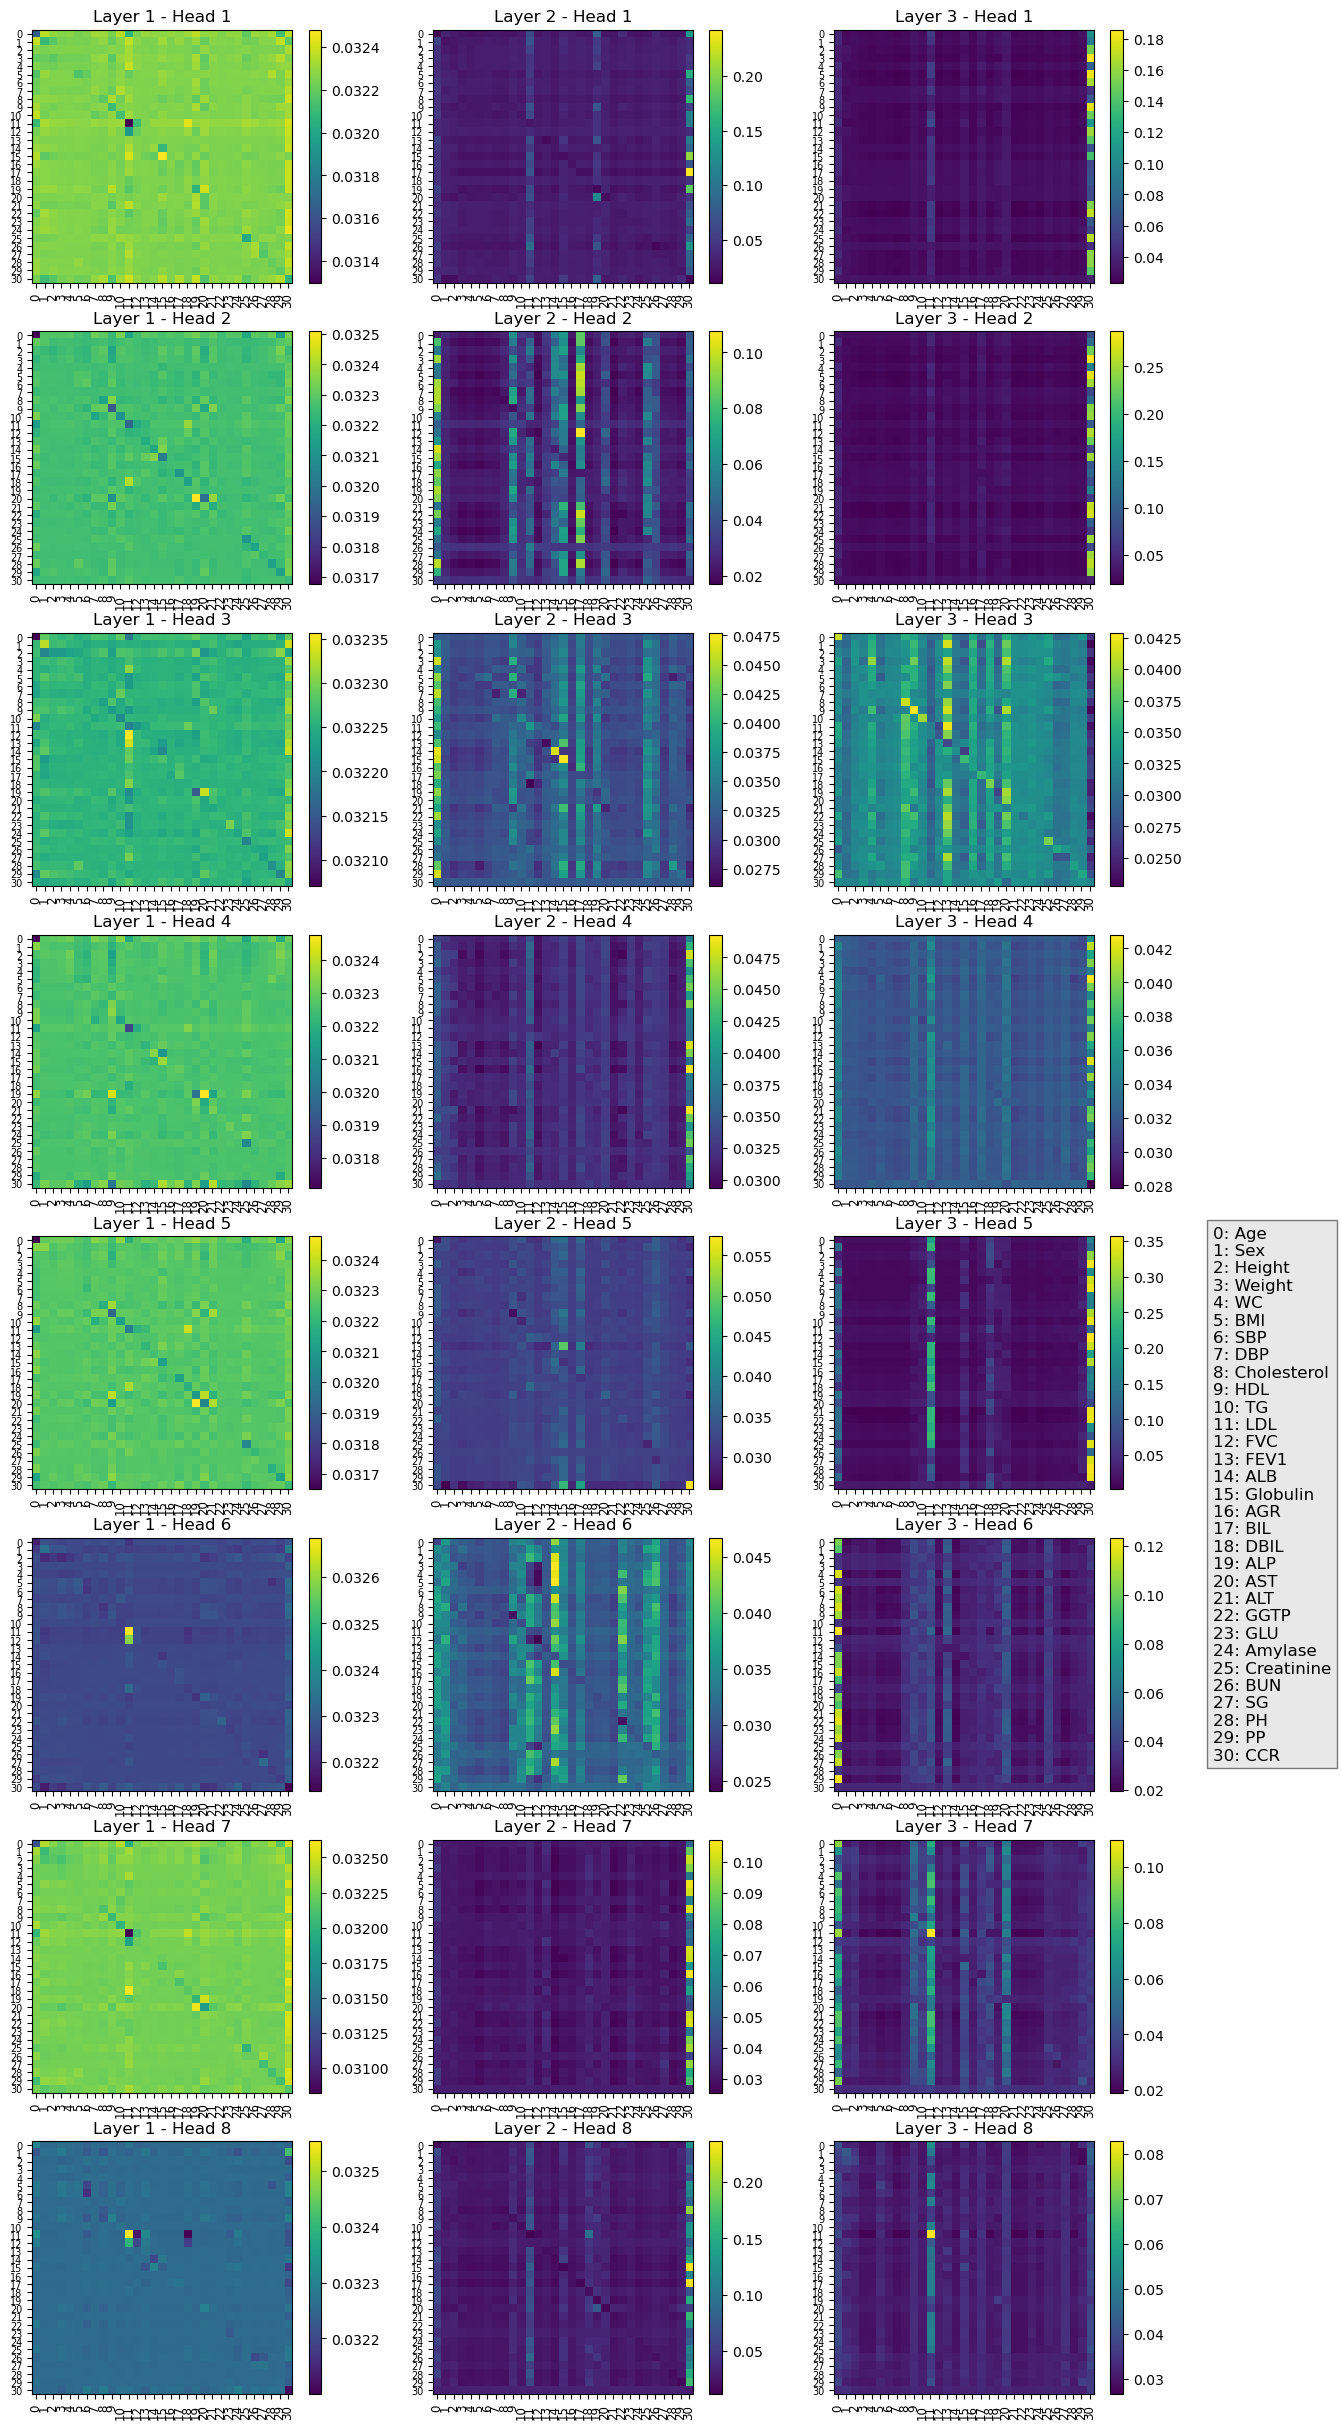

In [36]:
event_idx = 0
output = model1.predict(df_test, batch_size=None, event=event_idx)

NROW = model1.config['num_attention_heads'] #8
NCOL = model1.config['num_hidden_layers'] #1
fig, ax = plt.subplots(NROW, NCOL)
fig.set_figheight(30)
fig.set_figwidth(12)


E = 0
for i in range(NROW):
	for j in range(NCOL):        
		plt.subplot(NROW, NCOL, E+1)
		# plot_mean_curv(ARGS.tasks[E], ax[i, j])
		attention_heatmap(output[1], j, i, None, ax[i, j], fig) #FTR
		E += 1

annotation = '0: Age\n1: Sex\n2: Height\n3: Weight\n4: WC\n5: BMI\n6: SBP\n7: DBP\n8: Cholesterol\n9: HDL\n10: TG\n11: LDL\n12: FVC\n13: FEV1\n14: ALB\n15: Globulin\n16: AGR\n17: BIL\n18: DBIL\n19: ALP\n20: AST\n21: ALT\n22: GGTP\n23: GLU\n24: Amylase\n25: Creatinine\n26: BUN\n27: SG\n28: PH\n29: PP\n30: CCR'
fig.text(1.015, 0.5, annotation, 
		 ha='left', va='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom spacing to fit the text box
plt.show()

Try different task - Same attn matrix

In [ ]:
event_idx = 2
output = model1.predict(df_test, batch_size=None, event=event_idx)

NROW = model1.config['num_attention_heads'] #8
NCOL = model1.config['num_hidden_layers'] #1
fig, ax = plt.subplots(NROW, NCOL)
fig.set_figheight(30)
fig.set_figwidth(15)

E = 0
for i in range(NROW):
	for j in range(NCOL):        
		plt.subplot(NROW, NCOL, E+1)
		# plot_mean_curv(ARGS.tasks[E], ax[i, j])
		attention_heatmap(output[1], j, i, None, ax[i, j], fig) #FTR
		E += 1
		
fig.text(0.90, 0.5, 'This is a text box outside the subplots', 
		 ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom spacing to fit the text box
plt.show()

#### Group 2 - issue with attn layer 1

In [ ]:
GROUP = 1
SPARSE = True
SEED = 5
# PATH2 = './implement_checkpoints/trial_training/24-12-15_02.56.08_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt'
# PATH2 = './implement_checkpoints/trial_training/24-12-15_00.02.26_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt'
PATH2 = './implement_checkpoints/trial_training/24-12-14_08.03.56_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt'

hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
hp_list_dict = [json.loads(item) for item in hp_list]
tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

from survtrace.config import STConfig

STConfig['output_attentions'] = True #!!
STConfig['data'] = 'ysdat'
STConfig['initializer_range'] = .001
STConfig['early_stop_patience'] = 5
STConfig['horizons'] = CUTS
STConfig['model_name'] = f'ST-ysdat'

task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
STConfig['num_event'] = len(GROUP_LIST[GROUP])
STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
STConfig['hidden_size'] = tuned_hp['hidden_size']
STConfig['intermediate_size'] = tuned_hp['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

set_random_seed(SEED)
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

model2 = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model2.load_state_dict(torch.load(PATH2))
model2 = model2.to('cpu')

Inspect evaluation if model is loaded properly

In [ ]:
# Evaluate
evaluator = Evaluator(df, df_train.index)
metric_dict = evaluator.eval(model2, (df_test, df_y_test),val_batch_size=None, allow_all_censored=True, time_unit='years')


In [ ]:
event_idx = 3
output = model2.predict(df_test, batch_size=None, event=event_idx)

NROW = model2.config['num_attention_heads'] #8
NCOL = model2.config['num_hidden_layers'] #1
fig, ax = plt.subplots(NROW, NCOL)
fig.set_figheight(30)
fig.set_figwidth(15)

E = 0
for i in range(NROW):
	for j in range(NCOL):        
		plt.subplot(NROW, NCOL, E+1)
		# plot_mean_curv(ARGS.tasks[E], ax[i, j])
		attention_heatmap(output[1], j, i, None, ax[i, j], fig) #FTR
		E += 1
		
fig.text(0.90, 0.5, 'This is a text box outside the subplots', 
		 ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom spacing to fit the text box
plt.show()

In [ ]:
FTR = df_test.columns
attention_heatmap(output[1], 0, 0, FTR)

#### Group 2 - Try retraining with the 2nd best hparams

Trial 10 finished with value: 0.9122961509495072 and parameters: {'dropout': 0.2781413935916347, 'learning_rate': 0.0009275802099993313, 'batch_size': 256, 'hidden_size': 32, 'intermediate_size': 128, 'num_hidden_layers': 6, 'num_attention_heads': 4}.

In [6]:
tuned_hp2 = {'group': '1',
 'dropout': 0.2781413935916347,
 'learning_rate': 0.0009275802099993313,
 'batch_size': 256,
 'hidden_size': 32,
 'intermediate_size': 128,
 'num_hidden_layers': 6,
 'num_attention_heads': 4}

In [40]:
GROUP = 1
SPARSE = True
SEED = 5
# PATH2 = './implement_checkpoints/trial_training/24-12-15_02.56.08_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt'

# hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
# hp_list_dict = [json.loads(item) for item in hp_list]
# tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

from survtrace.config import STConfig

STConfig['output_attentions'] = True #!!
STConfig['data'] = 'ysdat'
STConfig['initializer_range'] = .001
STConfig['early_stop_patience'] = 5
STConfig['horizons'] = CUTS
STConfig['model_name'] = f'ST-ysdat'

task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
STConfig['num_event'] = len(GROUP_LIST[GROUP])
STConfig['attention_probs_dropout_prob'] = tuned_hp2['dropout']
STConfig['hidden_size'] = tuned_hp2['hidden_size']
STConfig['intermediate_size'] = tuned_hp2['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp2['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp2['num_attention_heads']

set_random_seed(SEED)
SMP = None
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS, sample=SMP)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

model2 = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
# mdl.load_state_dict(torch.load(PATH2))
# mdl = model2.to('cpu')

Using modified version of modeling_bert.py


In [9]:
# Train
trainer = Trainer(model2) ## Trainer2
train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val), ## , tag_outputs
		batch_size=tuned_hp2['batch_size'],
		epochs=20,
		learning_rate=tuned_hp2['learning_rate'],
		weight_decay=1e-4,)

use pytorch-cuda for training.
[Train-0]: 0.8395751231885332
[Val-0]: 0.165927916765213
[Train-1]: 0.17613973811738134
[Val-1]: 0.1670447438955307
EarlyStopping counter: 1 out of 5
[Train-2]: 0.16721793420593256
[Val-2]: 0.159368097782135
[Train-3]: 0.1677605338942191
[Val-3]: 0.15786010026931763
[Train-4]: 0.1640149178545619
[Val-4]: 0.155106320977211
[Train-5]: 0.16324758174733853
[Val-5]: 0.15682001411914825
EarlyStopping counter: 1 out of 5
[Train-6]: 0.163031290483287
[Val-6]: 0.1837896853685379
EarlyStopping counter: 2 out of 5
[Train-7]: 0.1620532125087939
[Val-7]: 0.1569032222032547
EarlyStopping counter: 3 out of 5
[Train-8]: 0.1618778843901993
[Val-8]: 0.15723279118537903
EarlyStopping counter: 4 out of 5
[Train-9]: 0.1643823330728166
[Val-9]: 0.15589195489883423
EarlyStopping counter: 5 out of 5
early stops at epoch 10


In [10]:
path = f'./implement_checkpoints/0204exp_ysdat_gr2.pt'
torch.save(model2.state_dict(), path)

In [11]:
# Evaluate
evaluator = Evaluator(df, df_train.index)
metric_dict = evaluator.eval(model2, (df_test, df_y_test), val_batch_size=None, allow_all_censored=True)

******************************
start evaluation
******************************
Event: 0 For 5 quantile,
TD Concordance Index - IPCW: 0.9487702362193869
Brier Score: 8.652561620316888e-05
Event: 0 For 10 quantile,
TD Concordance Index - IPCW: 0.9389423637365955
Brier Score: 0.0004384759118486458
Event: 0 For 15 quantile,
TD Concordance Index - IPCW: 0.8196319733062336
Brier Score: 0.033134601098088766
Event: 1 For 5 quantile,
TD Concordance Index - IPCW: 0.7500905343822902
Brier Score: 0.00017293188418323222
Event: 1 For 10 quantile,
TD Concordance Index - IPCW: 0.8274178212636984
Brier Score: 0.0005693566726453625
Event: 1 For 15 quantile,
TD Concordance Index - IPCW: 0.7203370302248739
Brier Score: 0.036900881009389805
Event: 2 For 5 quantile,
TD Concordance Index - IPCW: 0.9311260269654498
Brier Score: 0.00030154728094774005
Event: 2 For 10 quantile,
TD Concordance Index - IPCW: 0.9337735224156005
Brier Score: 0.0008675081092606122
Event: 2 For 15 quantile,
TD Concordance Index - IPC

In [41]:
path = f'./implement_checkpoints/0204exp_ysdat_gr2.pt'
model2_0 = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model2_0.load_state_dict(torch.load(path))
model2_0 = model2_0.to('cpu')

Using modified version of modeling_bert.py


In [ ]:
# state_dict = torch.load(path, map_location="cpu")

# # Print the keys (layer names)
# print(state_dict.keys())

odict_keys(['embeddings.num_embeddings', 'embeddings.word_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.attention.self.query.bias', 'encoder.layer.1.attention.self.key.weight', 'enco

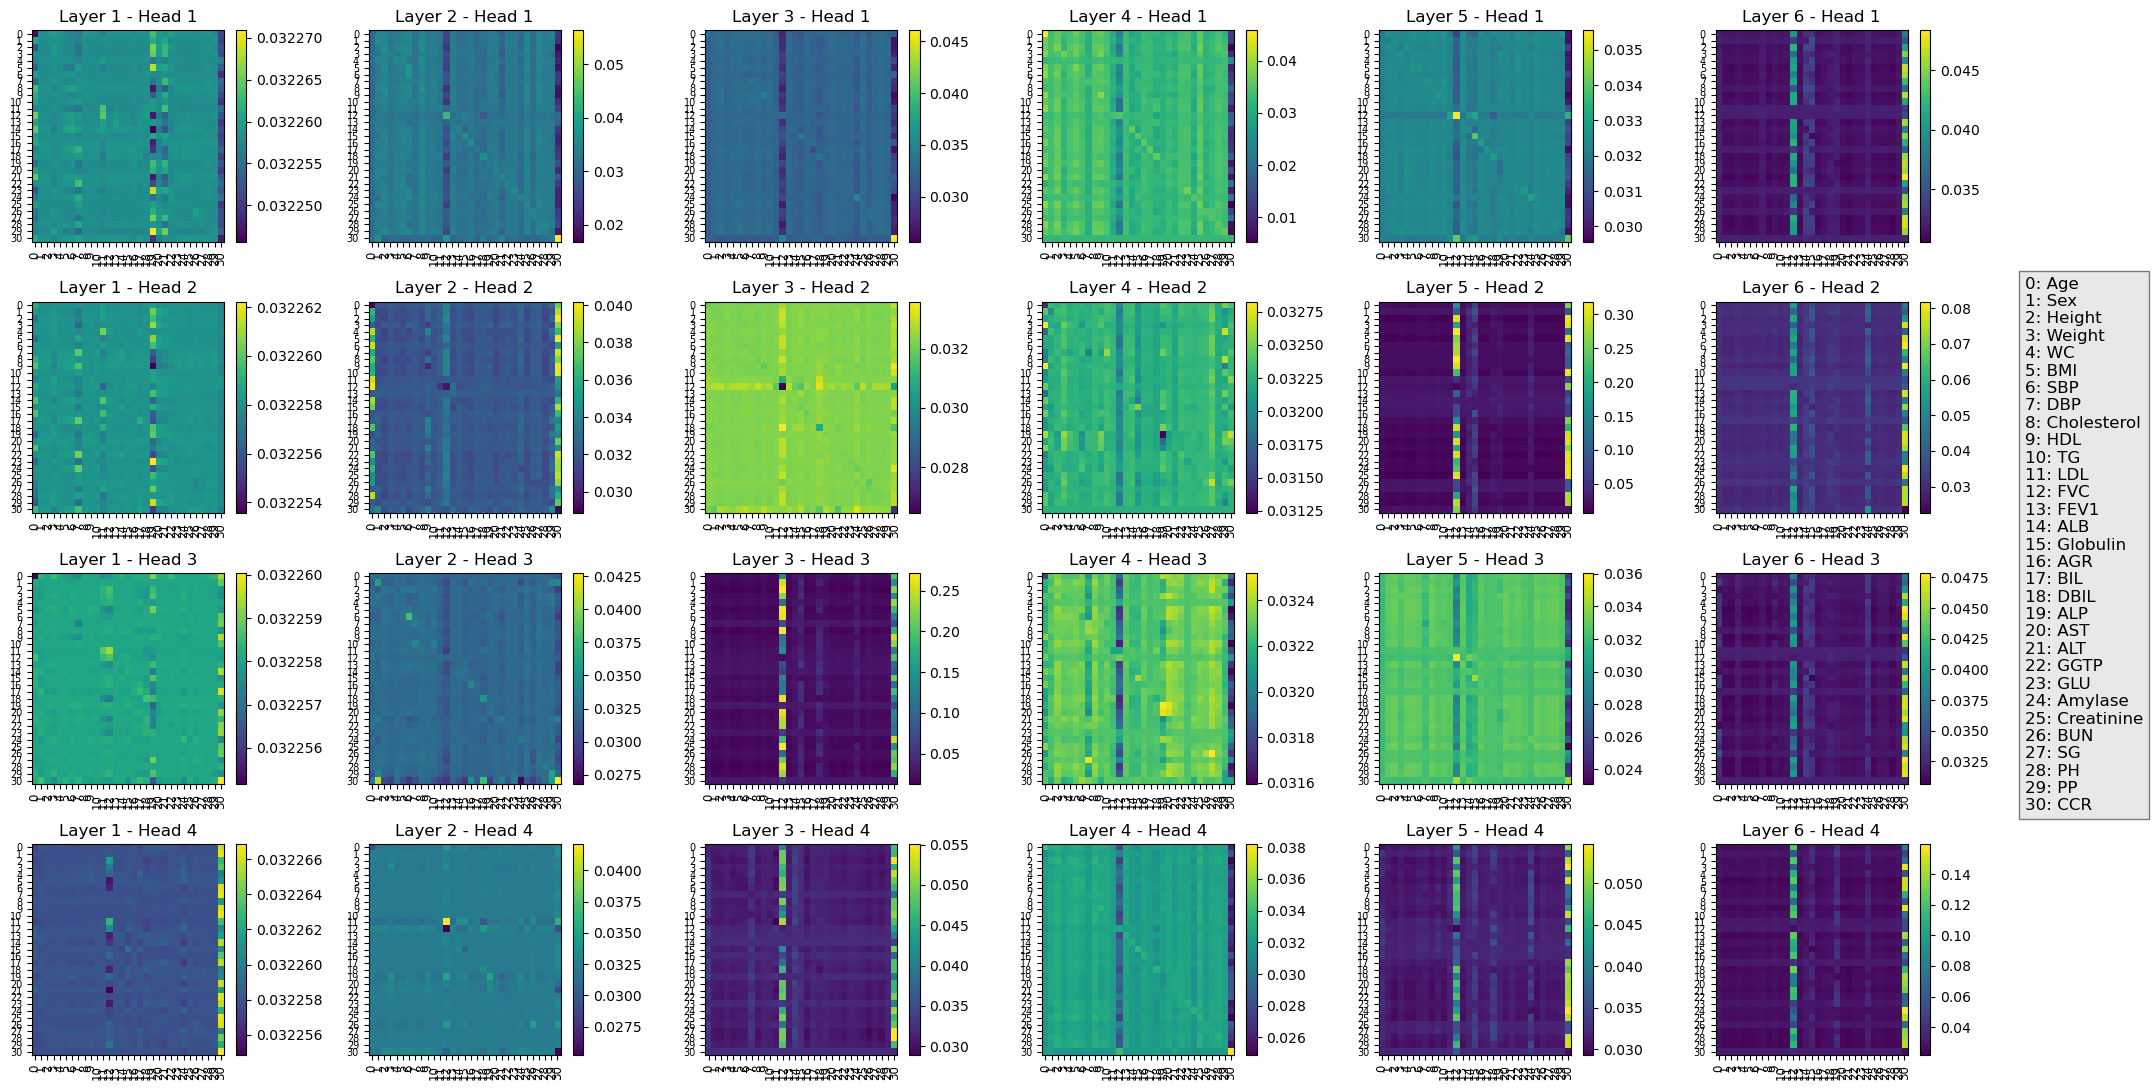

In [42]:
event_idx = 3
output = model2_0.predict(df_test, batch_size=None, event=event_idx)
# output = output.to('cpu')

NROW = model2_0.config['num_attention_heads'] #8
NCOL = model2_0.config['num_hidden_layers'] #1
fig, ax = plt.subplots(NROW, NCOL)
fig.set_figheight(11)
fig.set_figwidth(20)

E = 0
for i in range(NROW):
	for j in range(NCOL):        
		plt.subplot(NROW, NCOL, E+1)
		# plot_mean_curv(ARGS.tasks[E], ax[i, j])
		attention_heatmap(output[1], j, i, None, ax[i, j], fig) #FTR
		E += 1
		
annotation = '0: Age\n1: Sex\n2: Height\n3: Weight\n4: WC\n5: BMI\n6: SBP\n7: DBP\n8: Cholesterol\n9: HDL\n10: TG\n11: LDL\n12: FVC\n13: FEV1\n14: ALB\n15: Globulin\n16: AGR\n17: BIL\n18: DBIL\n19: ALP\n20: AST\n21: ALT\n22: GGTP\n23: GLU\n24: Amylase\n25: Creatinine\n26: BUN\n27: SG\n28: PH\n29: PP\n30: CCR'
fig.text(1.015, 0.5, annotation, 
		 ha='left', va='center', fontsize=12, bbox=dict(facecolor='lightgrey', alpha=0.5))
# Adjust layout

plt.subplots_adjust(bottom=0.2)  # Adjust bottom spacing to fit the text box
plt.tight_layout()
plt.show()


### Surv plot

Pred production and save

Load checkpoint and surv plot (example)

In [ ]:
# Define task and load model checkpoint #0705
E = 4
STConfig['task'] = ARGS.tasks[E]
print('Task:', STConfig['task'])

df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

# tuned_hp = json.loads(hp_list[E])
# DO = tuned_hp['dropout']
# LR = tuned_hp['learning_rate']
# BS = tuned_hp['batch_size']
# STConfig['attention_probs_dropout_prob'] = DO
# hparams = {
#         'batch_size': BS,
#         'weight_decay': 1e-4,
#         'learning_rate': LR,
#         'epochs': 20,
#     }

model_0 = SurvTraceSingle(STConfig)
##
model_0.load_state_dict(torch.load(f'./implement_checkpoints/24-07-08_17.38.54_LUNG.pt'))

surv = model_0.predict_surv(df_test, batch_size=None)

# Make dataframe and concat with df_y
surv_df = pd.DataFrame(surv.detach().numpy(), columns=model_0.config['duration_index'], index=df_y_test.index) # In case order retained
surv_test_df = pd.concat([surv_df, df_y_test], axis=1)
print(surv_test_df)

Plot surv curv by surv_test_df

In [ ]:
# surv_concat = surv_concat.rename(columns={"event": "label"})
durations_test_cb, events_test_cb = surv_test_df['duration'], surv_test_df['event']

# Generating input for plot
surv_concat = surv_test_df.drop(['duration'], axis=1)
# surv_concat = surv_concat.rename(columns={"label": "event"})
fig_df = surv_concat.groupby(by="event").mean() #.plot()

# Round up x-tickers
x_ticks = fig_df.columns.to_numpy(dtype=float) #.round(1)
fig_df.columns = x_ticks

# Plotting and save figure
plt.clf()
fig = fig_df.T.plot()
plt.title(f'Mean survival - {STConfig["task"]}')
plt.xlabel("Time (year)")
plt.ylabel("Probability")
plt.show()

now = datetime.now()
current_time = now.strftime("%y-%m-%d_%H.%M.%S")

Example of Kaplan Meier curves (or surv curves?) by real event group

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

kmf0 = KaplanMeierFitter()
T=surv_test_df['duration'] #telco_pd['tenure'] # Time
C=surv_test_df['event'] #telco_pd['churn'].astype(float) # Event
kmf0.fit(T,C)

kmf1 = KaplanMeierFitter()
surv_test_1 = surv_test_df[surv_test_df['event']==1]
T=surv_test_1['duration'] #telco_pd['tenure'] # Time
C=surv_test_1['event'] #telco_pd['churn'].astype(float) # Event
kmf1.fit(T,C)

In [ ]:
kc0 = kmf0.survival_function_ 
kc1 = kmf1.survival_function_

In [ ]:
kcs = pd.merge(kc0, kc1, left_index=True, right_index=True)
kcs.plot()

In [ ]:
# Attn matrix

In [ ]:
durations_test_cb, events_test_cb = surv_test_df['duration'], surv_test_df['event']

# Generating input for plot
surv_concat = surv_test_df.drop(['duration'], axis=1)
# surv_concat = surv_concat.rename(columns={"label": "event"})
fig_df = surv_concat.groupby(by="event").mean() #.plot()

# Round up x-tickers
x_ticks = fig_df.columns.to_numpy(dtype=float) #.round(1)
fig_df.columns = x_ticks

# Plotting and save figure
plt.clf()
fig = fig_df.T.plot()
plt.title(f'Mean survival - {STConfig["task"]}')
plt.xlabel("Time (year)")
plt.ylabel("Probability")
plt.show()

now = datetime.now()
current_time = now.strftime("%y-%m-%d_%H.%M.%S")

In [ ]:
fig_df.T

sc_w_ref = pd.merge(kcs, fig_df.T, left_index=True, right_index=True)
sc_w_ref.plot()

### ST Single - after tune

In [ ]:
from survtrace.model import SurvTraceSingle

Config

In [ ]:
EXTRA = 'Single'
SPARSE = False
SAMPLE = None
ALL_CEN = True

STConfig = EasyDict(
	{
		'data': 'ysdat', 
		'num_durations': 5, 
		'horizons': CUTS, 
		'seed': 1234,
		'checkpoint': './checkpoints/survtrace.pt',
		'vocab_size': 8, 
		'hidden_size': 16, 
		'intermediate_size': 64, 
		'num_hidden_layers': 3, 
		'num_attention_heads': 2, 
		'hidden_dropout_prob': 0.0,
		'num_feature': 9, 
		'num_numerical_feature': 5, 
		'num_categorical_feature': 4, 
		'out_feature':3, 
		'num_event': 1, 
		'hidden_act': 'gelu',
		'attention_probs_dropout_prob': 0.1,
		'early_stop_patience': 5,
		'initializer_range': 0.001,
		'layer_norm_eps': 1e-12,
		'max_position_embeddings': 512, 
		'chunk_size_feed_forward': 0, 
		'output_attentions': False, 
		'output_hidden_states': False, 
		'tie_word_embeddings': True, 
		'pruned_heads': {}, 
	}
)

set_random_seed(STConfig['seed'])
print(STConfig)

Tune by tuned_hparams.txt

In [ ]:
def get_hp(filename):
	with open(filename, 'r') as f:
		return [x.strip('\n') for x in f.readlines() if '#' not in x]
	
hp_list = get_hp('./implement_checkpoints/tuned_hparams_single_ysdat.txt') #tuned_hparams.txt
hp_list

In [ ]:
for E in range(len(ARGS.tasks)):
	now = datetime.now()
	current_time = now.strftime("%y-%m-%d_%H.%M.%S")
	MOD_NAME = EXTRA + f'{current_time}_task{E}_sparseFalse_cuts{CUTS}'
	STConfig['model_name'] = MOD_NAME
	
	STConfig['task'] = ARGS.tasks[E]
	STConfig['checkpoint'] = f'./checkpoints/survtrace_E{E}.pt'
	print('Training on:', STConfig['task'])

	# Hparams suggested by fine-tuning
	tuned_hp = json.loads(hp_list[E])
	# DO = tuned_hp['dropout']
	LR = tuned_hp['learning_rate']
	BS = tuned_hp['batch_size']
	
	STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
	STConfig['hidden_size'] = tuned_hp['hidden_size']
	STConfig['intermediate_size'] = tuned_hp['intermediate_size']
	STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers']
	STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

	hparams = {
		'batch_size': BS,
		'weight_decay': 1e-4,
		'learning_rate': LR,
		'epochs': N_EPOCHS, #20
	}

	# Load data
	df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS, sample=SAMPLE)

	# Get model
	model = SurvTraceSingle(STConfig)

	# Initialize a trainer
	trainer = Trainer(model)
	train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
			batch_size=hparams['batch_size'],
			epochs=hparams['epochs'],
			learning_rate=hparams['learning_rate'],
			weight_decay=hparams['weight_decay'],)

	# Save model
	path = f'./implement_checkpoints/{MOD_NAME}.pt'
	torch.save(model.state_dict(), path)

	# Log evaluation - c-ind
	evaluator = Evaluator(df, df_train.index)
	metric_dict = evaluator.eval(model, (df_test, df_y_test), allow_all_censored=ALL_CEN)
	c_indices = []
	for key in metric_dict.keys():
		if 'ipcw' in key:
			c_indices.append(metric_dict[key])
	 
	with open('./implement_checkpoints/c_ind_single_ysdat.txt', 'a') as f:
		f.write('\n')
		f.write(f"{STConfig['model_name']}: \n{metric_dict}")
		f.write('\n')
		for i in range(len(c_indices)):
			f.write(f'{c_indices[i]},')
			if (i + 1) % 3 == 0:
				f.write('\n')
				
	# Prediction surv prob


In [ ]:
STConfig['num_event']

Predict surv prob csv

In [ ]:
def predict_n_save(model, df_test, batch_size=None):    
	model.config['duration_index'][1:-1]
	horizons = model.config['horizons']
	surv = model.predict_surv(df_test, batch_size=batch_size)

	# Make dataframe and concat with df_y
	surv_df = pd.DataFrame(surv.detach().numpy(), columns=model.config['duration_index'], index=df_y_test.index) # In case order retained
	surv_test_df = pd.concat([surv_df, df_y_test], axis=1)
	# print(surv_test_df)

	# Save csv
	path = f'./implement_pred/{current_time}_{task}.csv'
	surv_test_df.to_csv(path)

08/07 try generating surv_test_df after creating new checkpoint

In [ ]:
for E in range(4, 5):
	STConfig['task'] = ARGS.tasks[E]
	STConfig['checkpoint'] = f'./checkpoints/survtrace_E{E}.pt'
	print('Training on:', STConfig['task'])

	# Hparams suggested by fine-tuning
	tuned_hp = json.loads(hp_list[E])
	DO = tuned_hp['dropout']
	LR = tuned_hp['learning_rate']
	BS = tuned_hp['batch_size']
	STConfig['attention_probs_dropout_prob'] = DO

	hparams = {
		'batch_size': BS,
		'weight_decay': 1e-4,
		'learning_rate': LR,
		'epochs': 20,
	}

	# Load data
	df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

	# Get model
	model = SurvTraceSingle(STConfig)

	# Initialize a trainer
	trainer = Trainer(model)
	train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
			batch_size=hparams['batch_size'],
			epochs=hparams['epochs'],
			learning_rate=hparams['learning_rate'],
			weight_decay=hparams['weight_decay'],)

	# Save model
	task = model.config['task']
	now = datetime.now()
	current_time = now.strftime("%y-%m-%d_%H.%M.%S")
	path = f'./implement_checkpoints/{current_time}_{task}.pt'
	torch.save(model.state_dict(), path)

	# Log evaluation - c-ind
	evaluator = Evaluator(df, df_train.index)
	with open('./implement_checkpoints/c_ind.txt', 'a') as f:
				f.write('\n')
				f.write(f'{current_time}_{task}: \n{evaluator.eval(model, (df_test, df_y_test))}')
				
	# Prediction surv prob
	model.config['duration_index'][1:-1]
	horizons = model.config['horizons']
	surv = model.predict_surv(df_test, batch_size=None)

	# Make dataframe and concat with df_y
	surv_df = pd.DataFrame(surv.detach().numpy(), columns=model.config['duration_index'], index=df_y_test.index) # In case order retained
	surv_test_df = pd.concat([surv_df, df_y_test], axis=1)
	# print(surv_test_df)

	# Save csv
	path = f'./implement_pred/{current_time}_{task}.csv'
	surv_test_df.to_csv(path)

In [ ]:
durations_test_cb, events_test_cb = surv_test_df['duration'], surv_test_df['event']

# Generating input for plot
surv_concat = surv_test_df.drop(['duration'], axis=1)
# surv_concat = surv_concat.rename(columns={"label": "event"})
fig_df = surv_concat.groupby(by="event").mean() #.plot()

# Round up x-tickers
x_ticks = fig_df.columns.to_numpy(dtype=float) #.round(1)
fig_df.columns = x_ticks

# Plotting and save figure
plt.clf()
fig = fig_df.T.plot()
plt.title(f'Mean survival - {STConfig["task"]}')
plt.xlabel("Time (year)")
plt.ylabel("Probability")
plt.show()


### Classification task

Use C-index for Threshold Optimization: assessing how well the model differentiates between individuals with different risk levels.

In [ ]:
from lifelines.utils import concordance_index
import numpy as np

In [ ]:
preds = model_0.predict(df_test, batch_size=None)
preds

In [ ]:
hazard = model_0.predict_hazard(df_test, batch_size=None)
hazard

In [ ]:
# Assess 0.25 quantile (?)
risk_scores = preds[:, 1].detach().numpy()
times_test, events_test = surv_test_df['duration'], surv_test_df['event']

# Function to calculate the C-index for a given threshold
from survtrace.plot_helper import calculate_c_index_for_threshold

# def calculate_c_index_for_threshold(threshold):
# 	high_risk = risk_scores > threshold
# 	# print(high_risk)
# 	low_risk = risk_scores <= threshold
# 	# Create a combined array of times and events for high and low risk groups
# 	combined_times = np.concatenate([times_test[high_risk], times_test[low_risk]])
# 	combined_events = np.concatenate([events_test[high_risk], events_test[low_risk]])
# 	# Create combined risk scores with high risk group as -1 and low risk as 1
# 	combined_risk = np.concatenate([-np.ones(sum(high_risk)), np.ones(sum(low_risk))])
# 	return concordance_index(combined_times, combined_risk, combined_events)

# # Define a range of thresholds to test
# thresholds = np.linspace(np.min(risk_scores), np.max(risk_scores), 100)
# best_threshold = None
# best_c_index = -np.inf

# # Iterate over thresholds to find the best one
# for threshold in thresholds:
# 	current_c_index = calculate_c_index_for_threshold(threshold)
# 	if current_c_index > best_c_index:
# 		best_c_index = current_c_index
# 		best_threshold = threshold

# print(f"Best Threshold: {best_threshold}, Best C-index: {best_c_index}")


In [ ]:
# Assess 0.5 quantile (?)
risk_scores = preds[:, 2].detach().numpy()

# Define a range of thresholds to test
thresholds = np.linspace(np.min(risk_scores), np.max(risk_scores), 100)
best_threshold = None
best_c_index = -np.inf

# Iterate over thresholds to find the best one
for threshold in thresholds:
	current_c_index = 
 
 _c_index_for_threshold(threshold) ## Modify arguments
	if current_c_index > best_c_index:
		best_c_index = current_c_index
		best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best C-index: {best_c_index}")

In [ ]:
# Assess 0.75 quantile (?)
risk_scores = preds[:, 3].detach().numpy()

# Define a range of thresholds to test
thresholds = np.linspace(np.min(risk_scores), np.max(risk_scores), 100)
best_threshold = None
best_c_index = -np.inf

# Iterate over thresholds to find the best one
for threshold in thresholds:
	current_c_index = calculate_c_index_for_threshold(threshold) ## Modify arguments
	if current_c_index > best_c_index:
		best_c_index = current_c_index
		best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best C-index: {best_c_index}")

Surv curves by high-low risk classification

In [ ]:
THRES = -6.205142197735384 # preds[:, 1]
# surv_test_df
# df_y_test
# df_test
preds = model_0.predict(df_test, batch_size=None)
clf = preds[:, 1] > THRES
clf = clf.detach().numpy()

In [ ]:
clf_np = clf.detach().numpy().astype(int)
df_y_test['clf'] = clf_np
df_y_test

In [ ]:
kmf0 = KaplanMeierFitter()
kmf1 = KaplanMeierFitter()


kmf0.fit(df_y_test['duration'][clf], df_y_test['event'][clf], label='High risk')
kmf1.fit(df_y_test['duration'][~clf], df_y_test['event'][~clf], label='Low risk')

pred_risk = pd.merge(kmf0.survival_function_, 
		 kmf1.survival_function_, 
		 left_index=True, right_index=True) #.plot()
pred_risk.plot()

In [ ]:
sc_w_ref = pd.merge(kcs, pred_risk, left_index=True, right_index=True)
sc_w_ref.plot()

Logrank test

In [ ]:
from lifelines.statistics import logrank_test
results = logrank_test(df_y_test['duration'][clf], 
					   df_y_test['duration'][~clf], 
					   event_observed_A=df_y_test['event'][clf], 
					   event_observed_B=df_y_test['event'][~clf])

results.print_summary()
print(results.p_value)        # 0.7676
print(results.test_statistic) # 0.0872

### Evaluation

ROC and AUROC

https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y_test = df_y_test['event'] # ground truth labels
y_probas = df_y_test['clf'] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probas)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Time-dependent AUROC

https://notebook.community/sebp/scikit-survival/examples/evaluating-survival-models

Example - chatGPT

In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Example data
data = pd.DataFrame({
	'time': [5, 6, 6, 2.5, 4, 10],
	'event': [1, 0, 1, 1, 0, 1],
	'x1': [10, 20, 10, 30, 20, 30],
	'x2': [1, 2, 3, 4, 5, 6]
})

# Split data into training and testing sets
train, test = train_test_split(data, test_size=0.3, random_state=42)

cph = CoxPHFitter()
cph.fit(train, duration_col='time', event_col='event')

test['risk_score'] = cph.predict_partial_hazard(test)

train_y = Surv.from_dataframe('event', 'time', train)
test_y = Surv.from_dataframe('event', 'time', test)
test_x = test.drop(columns=['time', 'event'])

times = np.linspace(0.1, max(test['time']), 100)  # Avoiding zero to prevent division errors
auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, test['risk_score'], times)

print(f'Mean AUROC: {mean_auc}')


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(times, auc, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('AUROC')
plt.title('Time-dependent ROC Curve')
plt.grid(True)
plt.show()


### Pred for 600obs data

#### Data processing

In [ ]:
# Reference: brier_retrain/br_rt_server-3-6.ipynb
df_f = pd.read_excel('../deployment/data/ma_check_data_female_2.xlsx')
df_m = pd.read_excel('../deployment/data/ma_check_data_male_2.xlsx')

df_600 = pd.concat([df_f, df_m], ignore_index=True)

df_600.rename(columns={'age_c': 'AGE_B', 
				   'sex_c': 'SEX1', 
				   'wt_c': 'WT_B', 
				   'ht_c': 'HT_B', 
				   'waist_c': 'WC', 
				   'bmi_c': 'BMI_B', 
				   'sbp_c': 'SBP_B', 
				   'dbp_c': 'DBP_B', 
				   'tc_c': 'CHO_B', 
				   'hdl_c': 'HDL_B', 
				   'tg_c': 'TG_B', 
				   'ldl_c': 'LDL_B', 
				   'fvc_c': 'FVC_B', 
				   'fev1_c': 'FEV1_B', 
				   'alb_c': 'ALB_B', 
				   'glo_c': 'GLOBULIN_B', 
				   'agr_c': 'AGR', 
				   'tb_c': 'BIL_B', 
				   'db_c': 'DBIL_B', 
				   'alp_c': 'ALP_B', 
				   'ast_c': 'AST',
				   'alt_c': 'ALT',
				   'ggtp_c': 'GGTP', 
				   'bs_c': 'GLU', 
				   'amylase_c': 'AMYLASE_B', 
				   'cr_c': 'CREAT_B', #?
				   'bun_c': 'BUN_B', 
				   'sg_c': 'SG', 
				   'ph_c': 'PH'}, inplace = True)

df_600['PP'] = df_600['SBP_B'] - df_600['DBP_B']
df_600['CCR'] = (140 - df_600['AGE_B']) * df_600['WT_B'] / (df_600['CREAT_B'] * 72)
df_600['CCR'][df_600['SEX1'] == 2] = df_600['CCR'] * .85

# df['CCR'] =  (140 - df['AGE_B']) * df['WT_B'] / (df['CREAT_B'] * 72)
# df['CCR'].where(df['SEX1'] == 2, df['CCR'] * 0.85)

# df_600['time'] = np.random.randint(1, 13, size=len(df_600))

df_600.describe()

#### Prediction

##### Load the latest model

In [ ]:
# # Load the latest model
# def get_model(task):
#     rootdir = os.getcwd() + '/implement_checkpoints/selected/'
#     # for task in ARGS.tasks:
#     regex = re.compile(f'(.*{task}.pt$)')
#     for root, dirs, files in os.walk(rootdir):
#         file_to_return = None
#         for file in files:
#             if regex.match(file):
#                 print(file)
#                 file_to_return = file

#             # Attempt to return the latest file
#     print('Reading file: ', file_to_return)

#     model = torch.load(rootdir + file_to_return)
#     return model

In [ ]:
pred_600 = copy.deepcopy(df_600)

In [ ]:
for E in range(len(ARGS.tasks)):
	STConfig['task'] = ARGS.tasks[E]
	model_0 = SurvTraceSingle(STConfig)
	model_0.load_state_dict(torch.load(f'./checkpoints/survtrace_E{E}.pt'))
	pred_df = model_0.predict_surv_df(df_600[df_train.columns]).T
	pred_df.columns = [STConfig['task'] + str(x) for x in pred_df.columns]
	pred_600 = pd.concat([pred_600, pred_df], axis = 1)

Check values STOMA, LUNG

In [ ]:
E = 1
STConfig['task'] = ARGS.tasks[E]
model_0 = SurvTraceSingle(STConfig)
model_0.load_state_dict(torch.load(f'./checkpoints/survtrace_E{E}.pt'))
pred_df_E1 = model_0.predict_surv_df(df_600[df_train.columns]).T
pred_df_E1

In [ ]:
E = 4
STConfig['task'] = ARGS.tasks[E]
model_0 = SurvTraceSingle(STConfig)
model_0.load_state_dict(torch.load(f'./checkpoints/survtrace_E{E}.pt'))
pred_df_E4 = model_0.predict_surv_df(df_600[df_train.columns]).T
pred_df_E4

In [ ]:
E = 7
STConfig['task'] = ARGS.tasks[E]
model_0 = SurvTraceSingle(STConfig)
model_0.load_state_dict(torch.load(f'./checkpoints/survtrace_E{E}.pt'))
pred_df_E7 = model_0.predict_surv_df(df_600[df_train.columns]).T
pred_df_E7

In [ ]:
pred_df_E7.value_counts()

In [ ]:
# print(df_600[df_train.columns].columns)
# print(df_train.columns)
model_0.predict_surv_df(df_train).T.value_counts()

Retrain models of E1/E4/E7

In [ ]:
hp_list = get_hp('./implement_checkpoints/tuned_hparams0-25.txt')
for E in [7]:
	STConfig['task'] = ARGS.tasks[E]
	STConfig['checkpoint'] = f'./checkpoints/survtrace_E{E}.pt'
	print('Training on:', STConfig['task'])

	# Hparams suggested by fine-tuning
	tuned_hp = json.loads(hp_list[E])
	DO = tuned_hp['dropout']
	LR = tuned_hp['learning_rate']
	BS = tuned_hp['batch_size']
	STConfig['attention_probs_dropout_prob'] = DO

	hparams = {
		'batch_size': BS,
		'weight_decay': 1e-4,
		'learning_rate': LR,
		'epochs': 20,
	}

	# Load data
	df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(STConfig)

	# Get model
	model = SurvTraceSingle(STConfig)

	# Initialize a trainer
	trainer = Trainer(model)
	train_loss, val_loss = trainer.fit((df_train, df_y_train), (df_val, df_y_val),
			batch_size=hparams['batch_size'],
			epochs=hparams['epochs'],
			learning_rate=hparams['learning_rate'],
			weight_decay=hparams['weight_decay'],)

	# Save model
	task = model.config['task']
	now = datetime.now()
	current_time = now.strftime("%y-%m-%d_%H.%M.%S")
	path = f'./implement_checkpoints/{current_time}_{task}.pt'
	torch.save(model.state_dict(), path)

	# Log evaluation - c-ind
	evaluator = Evaluator(df, df_train.index)
	with open('./implement_checkpoints/c_ind.txt', 'a') as f:
				f.write('\n')
				f.write(f'{current_time}_{task}: \n{evaluator.eval(model, (df_test, df_y_test))}')
				
	# Prediction surv prob
	model.config['duration_index'][1:-1]
	horizons = model.config['horizons']
	surv = model.predict_surv(df_test, batch_size=None)

	# Make dataframe and concat with df_y
	surv_df = pd.DataFrame(surv.detach().numpy(), columns=model.config['duration_index'], index=df_y_test.index) # In case order retained
	surv_test_df = pd.concat([surv_df, df_y_test], axis=1)
	# print(surv_test_df)

	# Save csv
	path = f'./implement_pred/{current_time}_{task}.csv'
	surv_test_df.to_csv(path)

Check value distribution

In [ ]:
for i in range(40, 85, 5):
	print(pred_600.iloc[:, i:i+5].value_counts())

Make plot of risk count

In [ ]:
keys = ARGS.tasks
values = [[574, 600-574], [600,0], [0, 600], [0, 600], ]
dictionary = dict(zip(keys, values))
risk_count = pd.DataFrame(data=dictionary)
risk_count

In [ ]:
pred_600[['STOMA0.0', 'STOMA11.5', 'STOMA12.2', 'STOMA12.7','STOMA15.9']] = pred_df_E1
pred_600[['STOMA0.0', 'STOMA11.5', 'STOMA12.2', 'STOMA12.7','STOMA15.9']]

In [ ]:
pred_600[['LUNG0.0', 'LUNG11.5', 'LUNG12.2', 'LUNG12.7', 'LUNG15.9']] = pred_df_E4
pred_600[['LUNG0.0', 'LUNG11.5', 'LUNG12.2', 'LUNG12.7', 'LUNG15.9']] 

In [ ]:
pred_600.to_csv('pred_600.csv')

#### Example

In [ ]:
# df_train = train3
df_test = df

col = copy.deepcopy(feature)
col.append('time')
col.append('label')

df_surv = copy.deepcopy(df)
df_surv = df_surv.iloc[:, :-12]

In [ ]:
for task in args.tasks:
	# Make input
	df_train['label'] = df_train[task]
	df_test['label'] = df_test[task]

	x_train = df_train[col].values.astype('float32')
	x_test = df[col].values.astype('float32') #?

	# Label processing
	labtrans = LabTransform(num_durations)
	get_target = lambda df: (df['time'].values, df['label'].values)
	y_train = labtrans.fit_transform(*get_target(df_train))
	
	# Model initialization
	in_features = x_train.shape[1]
	num_nodes_shared = [64, 64]  ### 64, 64
	num_nodes_indiv = [32] ### 32
	num_risks = 1 #y_train[1].max()
	out_features = num_durations #len(labtrans.cuts)
	batch_norm = True ### 
	dropout = 0.1 ### 0.1
	
	# # DeepHit
	
	# nDeep
	alpha=0.2
	sigma=0.1
	loss_dh = models.loss.DeepHitLoss(alpha, sigma)
	optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
							cycle_eta_multiplier=0.8)

	net = lstm0(input_size=x_train.shape[1]-2, ##
				loss=loss_dh,
				optimizer=optimizer,
				layer_hidden_sizes = [3,3,5], 
				num_layers = 3,
				bias = True,
				dropout = 0.2, ##
				bidirectional = False,
				batch_first = True,
				label_size = num_durations)
	model_nd = DeepHitSingle(net, optimizer, alpha=alpha, sigma=sigma,
					duration_index=labtrans.cuts)
	model_nd.load_model_weights(f'../brier_retrain/checkpoints/{task}_300.pt',
								map_location=torch.device('cpu'))
	
	# Prediction
	pseudo_input = (y_train[0][:len(df_test)], y_train[1][:len(df_test)]) #600
	# surv_dh = model_dh.predict_surv_df((x_test, pseudo_input))
	surv_nd = model_nd.predict_surv_df((x_test, pseudo_input)) #predict_surv_df
	ev1 = EvalSurv(surv_nd, durations_test,  #duration_test 
			   events_test==1, 
			   censor_surv='km')
	print(f'concordance_index - {task}: {ev1.concordance_td()}')
	# avg = surv_nd #(surv_dh + surv_nd)/2
	
	# new_idx = [task + str(x) for x in range(10)]
	# avg.index = new_idx
	
	# # Concatenate
	# df_surv = pd.concat([df_surv, avg.T], axis=1)
	

In [ ]:
df_surv.to_csv('../brier_retrain/df_predsurv.csv')

### Gaps between surv curv

In [ ]:
rootdir = os.getcwd() + '/implement_pred/'
regex = re.compile('(.*THROI.csv$)')

for root, dirs, files in os.walk(rootdir):
  file_to_print = None
  for file in files:
	if regex.match(file):
	  #  print(file)
	  file_to_print = file
	  
  # Attempt to return the latest file
  print(file_to_print)

In [ ]:
rootdir = os.getcwd() + '/implement_pred/'

for task in args.tasks:
	regex = re.compile(f'(.*{task}.csv$)')
	for root, dirs, files in os.walk(rootdir):
		file_to_return = None
		for file in files:
			if regex.match(file):
				file_to_return = file
	  
		# Attempt to return the latest file
		print('Reading file: ', file_to_return)
		
	path = rootdir + file_to_return
	surv_df = pd.read_csv(path, index_col=0)
	# surv_concat = surv_nd
	# surv_concat = surv_concat.reset_index() 
	
	# surv_concat = surv_concat.rename(columns={"event": "label"})
	# durations_test_cb, events_test_cb = get_target(surv_concat)

	# Surv curv
	surv_concat = surv_concat.drop(['index', 'time'], axis=1)
	surv_concat = surv_concat.rename(columns={"label": "event"})

	df_0 = surv_concat.groupby(by="event").mean().T
	df_0['diff'] = df_0[0] - df_0[1]
	print(df_0)

In [ ]:
surv_test_df
surv_concat = copy.deepcopy(surv_test_df)
surv_concat = surv_concat.drop(['duration'], axis=1)

df_0 = surv_concat.groupby(by="event").mean().T
df_0['diff'] = df_0[0] - df_0[1]
print(df_0)

In [ ]:
c_ind = evaluator.eval(model, (df_test, df_y_test))
c_ind

In [ ]:
(c_ind['0.25_ipcw'] + c_ind['0.5_ipcw'] + c_ind['0.75_ipcw'])/3

### Kaplan Meier fig input generation

#### KM curves

Best models loading (CanAttend Group 1, Group 2)

Fix train, test sets: Try to load the last trial model and with the respective seed: 29

In [ ]:
# from lifelines.utils import concordance_index
# from lifelines import KaplanMeierFitter
# from lifelines.statistics import logrank_test

In [ ]:
# Redefine STConfig
class args():
	def __init__(self):
		super(args, self).__init__()
		self.dataset = '../surv0913/dataset/ba8.csv' #yonsei_final_moa
		self.cancer = '../surv0913/dataset/cancers_new.txt'
		self.feature = '../surv0913/dataset/features.txt'
		self.test_rate = 0.2
		self.imputation = 'mean'
		self.by_sex = True
		self.tasks =  ['THROI', 'STOMA', 'BREAC', 'CRC', 'LUNG', 'PROST', 'LIVER', 'KIDNE', 'UTE_CER', 'LYMPH'] 
		self.new = True
		self.version = 2
		self.drop_normal = False
		# self.num_durations = DURATION
		# self.n_workers = N_WORKER
		self.n_epochs = 20
		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		
ARGS = args()      
cancer, cancer_time = get_cancers(ARGS.cancer)
feature0 = get_features(ARGS.feature)[1:] 
INP = len(feature0)

GROUP_LIST = [[0, 1, 5, 6, 7, 8, 9],
			  [2, 3, 4, 5, 6, 7, 8, 9],
			  [i for i in range(10)]]

CUTS = [5, 10, 15]

In [ ]:
STConfig['data'] = 'ysdat'
STConfig['initializer_range'] = .001
STConfig['early_stop_patience'] = 5
STConfig['horizons'] = CUTS
STConfig['model_name'] = f'ST-ysdat'

In [ ]:
def get_hp(filename):
		with open(filename, 'r') as f:
			return [x.strip('\n') for x in f.readlines() if '#' not in x]

hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
hp_list_dict = [json.loads(item) for item in hp_list]


In [ ]:
hp_list_dict

##### Plot distribution of follow up time of cases

In [ ]:
# ARGS.tasks[GROUP_LIST[0][i]] #[i]
# STConfig['task'] = ARGS.tasks
# df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) #4

for i in range(len(STConfig['task'])):
	nrow = int(i / 2)
	ncol = i % 2
	axs[nrow, ncol].hist(df.query(f'event_{i} == 1')['duration'])
	axs[nrow, ncol].set_title(f'{ARGS.tasks[i]}') # ARGS.tasks[GROUP_LIST[0][i]]}
	# df.query(f'event_{i} == 1')['duration'].hist()
	
fig.tight_layout()

##### Group 1

In [ ]:
GROUP = 0
SEED = 29
TEST_BATCH = None
UNIT = 'years'
SPARSE = True
ALL_CEN = True
PATH = './implement_checkpoints/trial_training/24-12-14_03.31.10_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group0.pt'

In [ ]:

task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
			
set_random_seed(SEED)

# Load hyperparams
tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

# hparams = {
# 	'batch_size': tuned_hp['batch_size'] ,
# 	'weight_decay': 1e-4,
# 	'learning_rate': tuned_hp['learning_rate'] ,
# 	'epochs': ARGS.n_epochs,
# }

STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
STConfig['hidden_size'] = tuned_hp['hidden_size']
STConfig['intermediate_size'] = tuned_hp['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']
			
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

Check if evaluation exact as trialrun1213 results - Trial: 29

In [ ]:
# Load model
model = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model.load_state_dict(torch.load(PATH))
model = model.to('cpu')

In [ ]:
# # Evaluate
# evaluator = Evaluator(df, df_train.index)
# metric_dict = evaluator.eval(model, (df_test, df_y_test),val_batch_size=TEST_BATCH, allow_all_censored=ALL_CEN, time_unit=UNIT)


##### Draw KM figures

Calculate list of thresholds at 10 yrs

In [ ]:
df_y_train2 = copy.deepcopy(df_y_train)
df_y_train2['duration'] = df.loc[df_y_train2.index, 'duration']

In [ ]:
CUT_IDX = 1

threshold_list = []
for i in range(len(STConfig['task'])):
	threshold = calculate_c_index_for_threshold((df_train, df_y_train2), event_idx=i, cut_idx=CUT_IDX, c_ind=False, verbose=True)
	threshold_list.append(threshold)

In [ ]:
threshold_list

In [ ]:
threshold_list

Check result on test set

In [ ]:
CUT_IDX = 1 # 10yrs
df_x, df_y = df_test, df_y_test
event_idx = 0

# Calculate risk score
preds = model.predict(df_x, batch_size=None, event=event_idx)[0] ## no need [0] before
risk_scores = preds[:, CUT_IDX+1].detach().numpy()

times_test, events_test = df_y['duration'], df_y[f'event_{event_idx}'] #['event']

# Define a range of thresholds to test
thresholds = np.linspace(np.min(risk_scores), np.max(risk_scores), 100)
best_threshold = None
best_c_index = -np.inf

# Iterate over thresholds to find the best one
# for threshold in thresholds:
threshold0 = threshold_list[event_idx]
print('Threshold: ', threshold0)
high_risk = risk_scores > threshold0
low_risk = risk_scores <= threshold0

# Create a combined array of times and events for high and low risk groups
combined_times = np.concatenate([times_test[high_risk], times_test[low_risk]])
combined_events = np.concatenate([events_test[high_risk], events_test[low_risk]])

# Create combined risk scores with high risk group as -1 and low risk as 1
combined_risk = np.concatenate([-np.ones(sum(high_risk)), np.ones(sum(low_risk))])

# current_c_index = calculate_c_index_for_threshold(event_idx=0, cut_idx=1, threshold=threshold)
current_c_index = concordance_index(combined_times, combined_risk, combined_events)
print('C-ind: ', current_c_index)

In [ ]:
threshold_list

threshold_list = [-2.7499425471431076,
 -3.8041473518718374,
 -4.3220630781819125,
 -5.22850925753815,
 -5.180346180694272,
 -4.409018355186539,
 -5.416082122109152]

Try plotting KM curves

In [ ]:
## Check result on test set
df_x, df_y = df_test, df_y_test
event_idx = 0

# Calculate risk score
preds = model.predict(df_x, batch_size=None, event=event_idx)[0] ## no need [0] before
risk_scores = preds[:, CUT_IDX+1].detach().numpy()

times_test, events_test = df_y['duration'], df_y[f'event_{event_idx}'] #['event']

plot_km_curv(STConfig['task'][event_idx], threshold_list[event_idx], risk_scores, (times_test, events_test), ax=None)

Try drawing KM curves with threshold based on 15 yrs - poor performance

In [ ]:
threshold15 = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=0, cut_idx=2)

## Check result on test set
df_x, df_y = df_test, df_y_test
event_idx = 0

# Calculate risk score
preds = model.predict(df_x, batch_size=None, event=event_idx)[0] ## no need [0] before
risk_scores = preds[:, 2+1].detach().numpy() # cut_idx

times_test, events_test = df_y['duration'], df_y[f'event_{event_idx}'] #['event']

plot_km_curv(STConfig['task'][event_idx], threshold15, risk_scores, (times_test, events_test), ax=None)

##### Plotting individual curve vs reference curves

In [ ]:
df_y_test5 = df_y_test.query('event_0 == 1 and duration <= 5')
# df_y_test5
df_y_test10 = df_y_test.query('event_0 == 1 and duration <= 10 and duration > 5')

In [ ]:
STConfig['horizons']
df['duration'].max()

In [ ]:
threshold_list = [-2.7499425471431076,
 -3.8041473518718374,
 -4.3220630781819125,
 -5.22850925753815,
 -5.180346180694272,
 -4.409018355186539,
 -5.416082122109152]


km_curves(43180, event_idx=0, threshold_list=threshold_list)

Sample 10 non cases,  10 event_0 cases: 2 <5, 5 5-10, 3 >10

In [ ]:
event_list = [f'event_{i}' for i in range(len(STConfig['task']))]
df0 = df_y_test[df_y_test[event_list].sum(axis=1) == 0].sample(10)
df0

In [ ]:
df_test0 = df_test.loc[df0.index]


In [ ]:
index1 = df_y_test.query('event_0==1 and duration <=5').sample(2).index
# df_test.loc[] #.sample(2)]
index1

In [ ]:
df1 = df_test.loc[index1]

In [ ]:
index2 = df_y_test.query('event_0==1 and duration >5 and duration <=10').sample(5).index
df2 = df_test.loc[index2]


In [ ]:
index3 = df_y_test.query('event_0==1 and duration > 10').sample(3).index
df3 = df_test.loc[index3]


In [ ]:
df1_1 = pd.concat([df1, df2, df3])

In [ ]:
# Draw subplots
event_idx = 0
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) #4

for i in range(len(df0)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df0.iloc[i].name, event_idx=event_idx, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()


In [ ]:
# Subplot for non cases again
df0 = df_y_test[df_y_test[event_list].sum(axis=1) == 0].sample(10)
# Draw subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) #4

for i in range(len(df0)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df0.iloc[i].name, event_idx=0, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

In [ ]:
# Draw subplots for event cases
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) #4

for i in range(len(df1_1)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df1_1.iloc[i].name, event_idx=0, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

Try with Prostate (event2)

In [ ]:
# Subplot for non cases again
df0 = df_y_test[df_y_test[event_list].sum(axis=1) == 0].sample(10)
# Draw subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) #4

for i in range(len(df0)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df0.iloc[i].name, event_idx=2, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

In [ ]:
# df0 = df_y_test[df_y_test[event_list].sum(axis=1) == 0].sample(10)
index1 = df_y_test.query('event_2==1 and duration <=5').sample(2).index
df1 = df_test.loc[index1]
index2 = df_y_test.query('event_2==1 and duration >5 and duration <=10').sample(5).index
df2 = df_test.loc[index2]
index3 = df_y_test.query('event_2==1 and duration > 10').sample(3).index
df3 = df_test.loc[index3]
df1_1 = pd.concat([df1, df2, df3])

# Draw subplots for event cases
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) #4

for i in range(len(df1_1)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df1_1.iloc[i].name, event_idx=2, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

##### Calculate avg score for case < 5 and <10 yrs

In [ ]:
import copy

In [ ]:
df_y_test_result = copy.deepcopy(df_y_test)

In [ ]:
# event_idx = 0
# cut_idx = 0

for cut_idx in range(2):
	print(f'At time frame: {CUTS[cut_idx]} years')
	for event_idx in range(len(STConfig['task'])):
		print(' Event id: ', event_idx) 
		# Calculate risk score
		preds = model.predict_surv(df_test, batch_size=None, event=event_idx) #[0] 

		df_y_test_result[f'risk_score_{event_idx}'] = preds[:, cut_idx+1].detach().numpy()

		mean_1 = df_y_test_result.query(f'duration <= {CUTS[cut_idx]} and event_{event_idx} ==1')[f'risk_score_{event_idx}'].mean()

		mean_0 = df_y_test_result.query(f'duration <= {CUTS[cut_idx]} and event_{event_idx} ==0')[f'risk_score_{event_idx}'].mean()

		print(f' Mean of survival probability of event cases - {mean_1}, censored cases - {mean_0}')


##### Group 2

In [ ]:
GROUP = 1
SEED = 29
TEST_BATCH = None
UNIT = 'years'
SPARSE = True
ALL_CEN = True
PATH = './implement_checkpoints/trial_training/24-12-15_02.56.08_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt'

In [ ]:
task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
set_random_seed(SEED)

# Load hyperparams
tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

# hparams = {
# 	'batch_size': tuned_hp['batch_size'] ,
# 	'weight_decay': 1e-4,
# 	'learning_rate': tuned_hp['learning_rate'] ,
# 	'epochs': ARGS.n_epochs,
# }

STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
STConfig['hidden_size'] = tuned_hp['hidden_size']
STConfig['intermediate_size'] = tuned_hp['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']
			
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

In [ ]:
model = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model.load_state_dict(torch.load(PATH))
model = model.to('cpu')

In [ ]:
# Evaluate
# evaluator = Evaluator(df, df_train.index)
# metric_dict = evaluator.eval(model, (df_test, df_y_test),val_batch_size=TEST_BATCH, allow_all_censored=ALL_CEN, time_unit=UNIT)


##### Draw KM figures

Calculate list of thresholds at 10yrs

In [ ]:
CUT_IDX = 1

threshold_list = []
for i in range(len(STConfig['task'])):
	threshold = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=i, cut_idx=CUT_IDX)
	threshold_list.append(threshold)

In [ ]:
threshold_list

threshold_list = [-5.497918128967285,
 -3.977186947157888,
 -4.571382128831113,
 -4.661104183606426,
 -5.008902164420695,
 -5.268686228328281,
 -6.795355103232643,
 -5.259275536344509]

Try plotting KM curves

In [ ]:
## Check result on test set
event_idx = 0

# Calculate risk score
preds = model.predict(df_test, batch_size=None, event=event_idx)[0] ## no need [0] before
risk_scores = preds[:, CUT_IDX+1].detach().numpy()

times_test, events_test = df_y_test['duration'], df_y_test[f'event_{event_idx}'] #['event']

plot_km_curv(STConfig['task'][event_idx], threshold_list[event_idx], risk_scores, (times_test, events_test), ax=None)

##### Ploting individual curve vs reference curves

In [ ]:
threshold_list = [-5.497918128967285,
 -3.977186947157888,
 -4.571382128831113,
 -4.661104183606426,
 -5.008902164420695,
 -5.268686228328281,
 -6.795355103232643,
 -5.259275536344509]

In [ ]:
event_list = [f'event_{i}' for i in range(len(STConfig['task']))]
df0 = df_y_test[df_y_test[event_list].sum(axis=1) == 0].sample(10)

index1 = df_y_test.query('event_0==1 and duration <=5').sample(2).index
df1 = df_test.loc[index1]

index2 = df_y_test.query('event_0==1 and duration >5 and duration <=10').sample(5).index
df2 = df_test.loc[index2]

index3 = df_y_test.query('event_0==1 and duration > 10').sample(3).index
df3 = df_test.loc[index3]

df1_1 = pd.concat([df1, df2, df3])


Subplots for df0 - event 0

In [ ]:
event_idx = 0
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) 

for i in range(len(df0)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df0.iloc[i].name, event_idx=event_idx, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

Subplots for df1_1 - event0

In [ ]:
event_idx = 0
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) 

for i in range(len(df1_1)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df1_1.iloc[i].name, event_idx=event_idx, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

Subplots for df0 - event 3

In [ ]:
event_list = [f'event_{i}' for i in range(len(STConfig['task']))]
df0 = df_y_test[df_y_test[event_list].sum(axis=1) == 0].sample(10)

index1 = df_y_test.query('event_3==1 and duration <=5').sample(2).index
df1 = df_test.loc[index1]

index2 = df_y_test.query('event_3==1 and duration >5 and duration <=10').sample(5).index
df2 = df_test.loc[index2]

index3 = df_y_test.query('event_3==1 and duration > 10').sample(3).index
df3 = df_test.loc[index3]

df1_1 = pd.concat([df1, df2, df3])

In [ ]:
event_idx = 3
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) 

for i in range(len(df0)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df0.iloc[i].name, event_idx=event_idx, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

Subplots for df1_1 - event3

In [ ]:
event_idx = 3
fig, axs = plt.subplots(5, 2, figsize=(10, 10)) 

for i in range(len(df1_1)):
	nrow = int(i / 2)
	ncol = i % 2
	km_curves(df1_1.iloc[i].name, event_idx=event_idx, threshold_list=threshold_list, cut_expand=Cut_expand, ax=axs[nrow, ncol])
	
fig.tight_layout()

#### Plot ROC - AUC

##### Shared functions

In [7]:
# Redefine STConfig
from survtrace.config import STConfig

class args():
	def __init__(self):
		super(args, self).__init__()
		self.dataset = '../surv0913/dataset/ba8.csv' #yonsei_final_moa
		self.cancer = '../surv0913/dataset/cancers_new.txt'
		self.feature = '../surv0913/dataset/features.txt'
		self.test_rate = 0.2
		self.imputation = 'mean'
		self.by_sex = True
		self.tasks =  ['THROI', 'STOMA', 'BREAC', 'CRC', 'LUNG', 'PROST', 'LIVER', 'KIDNE', 'UTE_CER', 'LYMPH'] 
		self.new = True
		self.version = 2
		self.drop_normal = False
		self.n_epochs = 20
		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		
ARGS = args()      
cancer, cancer_time = get_cancers(ARGS.cancer)
feature0 = get_features(ARGS.feature)[1:] 
INP = len(feature0)

GROUP_LIST = [[0, 1, 5, 6, 7, 8, 9],
			  [2, 3, 4, 5, 6, 7, 8, 9],
			  [i for i in range(10)]]

CUTS = [5, 10, 15]

STConfig['data'] = 'ysdat'
STConfig['initializer_range'] = .001
STConfig['early_stop_patience'] = 5
STConfig['horizons'] = CUTS
STConfig['model_name'] = f'ST-ysdat'

hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
hp_list_dict = [json.loads(item) for item in hp_list]

STConfig['task'] = ARGS.tasks
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)

##### Group 1

In [10]:
# threshold_list = [-2.7499425471431076,
#  -3.8041473518718374,
#  -4.3220630781819125,
#  -5.22850925753815,
#  -5.180346180694272,
#  -4.409018355186539,
#  -5.416082122109152]

In [ ]:
GROUP = 0
SEED = 29
TEST_BATCH = None
UNIT = 'years'
SPARSE = True
ALL_CEN = True
PATH = './implement_checkpoints/trial_training/24-12-14_03.31.10_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group0.pt'

task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
			
set_random_seed(SEED)

# Load hyperparams
tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
STConfig['hidden_size'] = tuned_hp['hidden_size']
STConfig['intermediate_size'] = tuned_hp['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']
			
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

# Load model
model = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model.load_state_dict(torch.load(PATH))
model = model.to('cpu')

In [ ]:
# Example - Group1 event 0
event_idx = 0
THRES = -2.7499425471431076 #threshold_list[event_idx] #Found through calculate_c_index_for_threshold()
plot_roc(event_idx, THRES, model, df_test, df_y_test)

Loop and subplots

In [ ]:
CUT_IDX = 1
# threshold_list_rsf = []
fig, ax = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(15)

threshold_list = [-2.6679717218032994,
 -3.7994330362840136,
 -4.556072115898132,
 -5.203126888082485,
 -5.186669012512823,
 -4.401677097937073,
 -5.501650184091895]

for i in range(len(STConfig['task'])):
	event_idx = i
	nrow = int(i / 2)
	ncol = i %2
 
	# rsf = model[f'model_{event_idx}']
	rsf_pred_train = model.predict(df_train, event=i)
	# threshold = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=event_idx, cut_idx=CUT_IDX, risk_scores=rsf_pred_train.value, c_ind=False, verbose=True)
	# threshold_list_rsf.append(threshold)
	
	THRES = threshold_list[i]
	plot_roc(event_idx, THRES, model, df_test, df_y_test, cut_idx=CUT_IDX, model_type='st', ax=ax[nrow, ncol], event_name=STConfig['task'][i])

fig.suptitle("CanAttend - Group 1", fontsize=16)
fig.tight_layout()	

##### Group 2

In [ ]:
GROUP = 1
SEED = 29
TEST_BATCH = None
UNIT = 'years'
SPARSE = True
ALL_CEN = True
PATH = './implement_checkpoints/trial_training/24-12-15_02.56.08_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt'

task_indices = GROUP_LIST[GROUP]
STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
			
set_random_seed(SEED)

# Load hyperparams
tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
STConfig['hidden_size'] = tuned_hp['hidden_size']
STConfig['intermediate_size'] = tuned_hp['intermediate_size']
STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']
			
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]

# Load model
model = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
model.load_state_dict(torch.load(PATH))
model = model.to('cpu')

In [ ]:
CUT_IDX = 1
# threshold_list_rsf = []
fig, ax = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(15)

threshold_list = [-5.497918128967285,
 -3.977186947157888,
 -4.571382128831113,
 -4.661104183606426,
 -5.008902164420695,
 -5.268686228328281,
 -6.795355103232643,
 -5.259275536344509]

for i in range(len(STConfig['task'])):
	event_idx = i
	nrow = int(i / 2)
	ncol = i %2
 
	# rsf = model[f'model_{event_idx}']
	rsf_pred_train = model.predict(df_train, event=i)
	# threshold = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=event_idx, cut_idx=CUT_IDX, risk_scores=rsf_pred_train.value, c_ind=False, verbose=True)
	# threshold_list_rsf.append(threshold)
	
	THRES = threshold_list[i]
	plot_roc(event_idx, THRES, model, df_test, df_y_test, cut_idx=CUT_IDX, model_type='st', ax=ax[nrow, ncol], event_name=STConfig['task'][i])

fig.suptitle("CanAttend - Group 2", fontsize=16)
fig.tight_layout()		

##### ST Single

In [7]:
from survtrace.model import SurvTraceSingle

from survtrace.config import STConfig

EXTRA = 'Single'
SPARSE = False
SAMPLE = None
ALL_CEN = True
CUTS = [5, 10, 15]

SEED = 10

class args():
	def __init__(self):
		super(args, self).__init__()
		self.dataset = '../surv0913/dataset/ba8.csv' #yonsei_final_moa
		self.cancer = '../surv0913/dataset/cancers_new.txt'
		self.feature = '../surv0913/dataset/features.txt'
		self.test_rate = 0.2
		self.imputation = 'mean'
		self.by_sex = True
		self.tasks =  ['THROI', 'STOMA', 'BREAC', 'CRC', 'LUNG', 'PROST', 'LIVER', 'KIDNE', 'UTE_CER', 'LYMPH'] 
		self.new = True
		self.version = 2
		self.drop_normal = False
		self.n_epochs = 20
		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		
ARGS = args()      
cancer, cancer_time = get_cancers(ARGS.cancer)
feature0 = get_features(ARGS.feature)[1:] 
INP = len(feature0)

STConfig['data'] = 'ysdat'
STConfig['initializer_range'] = .001
STConfig['early_stop_patience'] = 5
STConfig['horizons'] = CUTS
STConfig['model_name'] = f'ST-ysdat'


STConfig['task'] = ARGS.tasks
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS)
# Cut_expand = [0.0] + STConfig['horizons'] + [df['duration'].max()]


In [8]:
hp_list = get_hp('./implement_checkpoints/tuned_hparams_single_ysdat.txt') 
hp_list_dict = [json.loads(item) for item in hp_list]

# Retrieving from ./optuna_ckt/trialrun1229_ysdat_single.txt
model_st29_list = [
    # '24-12-29_18.19.22_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task0',
   	'24-12-29_17.07.33_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task0', # trial 10 instead
    '24-12-29_22.39.14_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task1',
    # '24-12-30_06.03.22_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task2',
    '24-12-30_01.19.02_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task2', # trial 10 instead
	'24-12-30_11.06.02_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task3',
	'24-12-30_13.07.04_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task4',
	'24-12-30_15.15.40_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task5',
	'24-12-30_18.55.57_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task6',
	'24-12-30_20.56.25_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task7',
	# '24-12-31_00.46.37_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task8',
	'24-12-30_22.34.23_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task8', # trial 10 instead
	'24-12-31_06.13.31_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task9'
    ]

In [9]:
model_st_dict = {}

for i in range(len(STConfig['task'])): # Should be 10
	tuned_hp = next((item for item in hp_list_dict if item["task"] == f'E{i}'), None) #json.loads(hp_list[E])

	STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
	STConfig['hidden_size'] = tuned_hp['hidden_size']
	STConfig['intermediate_size'] = tuned_hp['intermediate_size']
	STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
	STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

	model = SurvTraceSingle(STConfig).to("cuda")
	model.load_state_dict(torch.load(f'./implement_checkpoints/trial_training/{model_st29_list[i]}.pt'))
	model = model.to('cpu')
	model_st_dict[f'model_{i}'] = model
 

Example

In [10]:
from survtrace.plot_helper import plot_roc

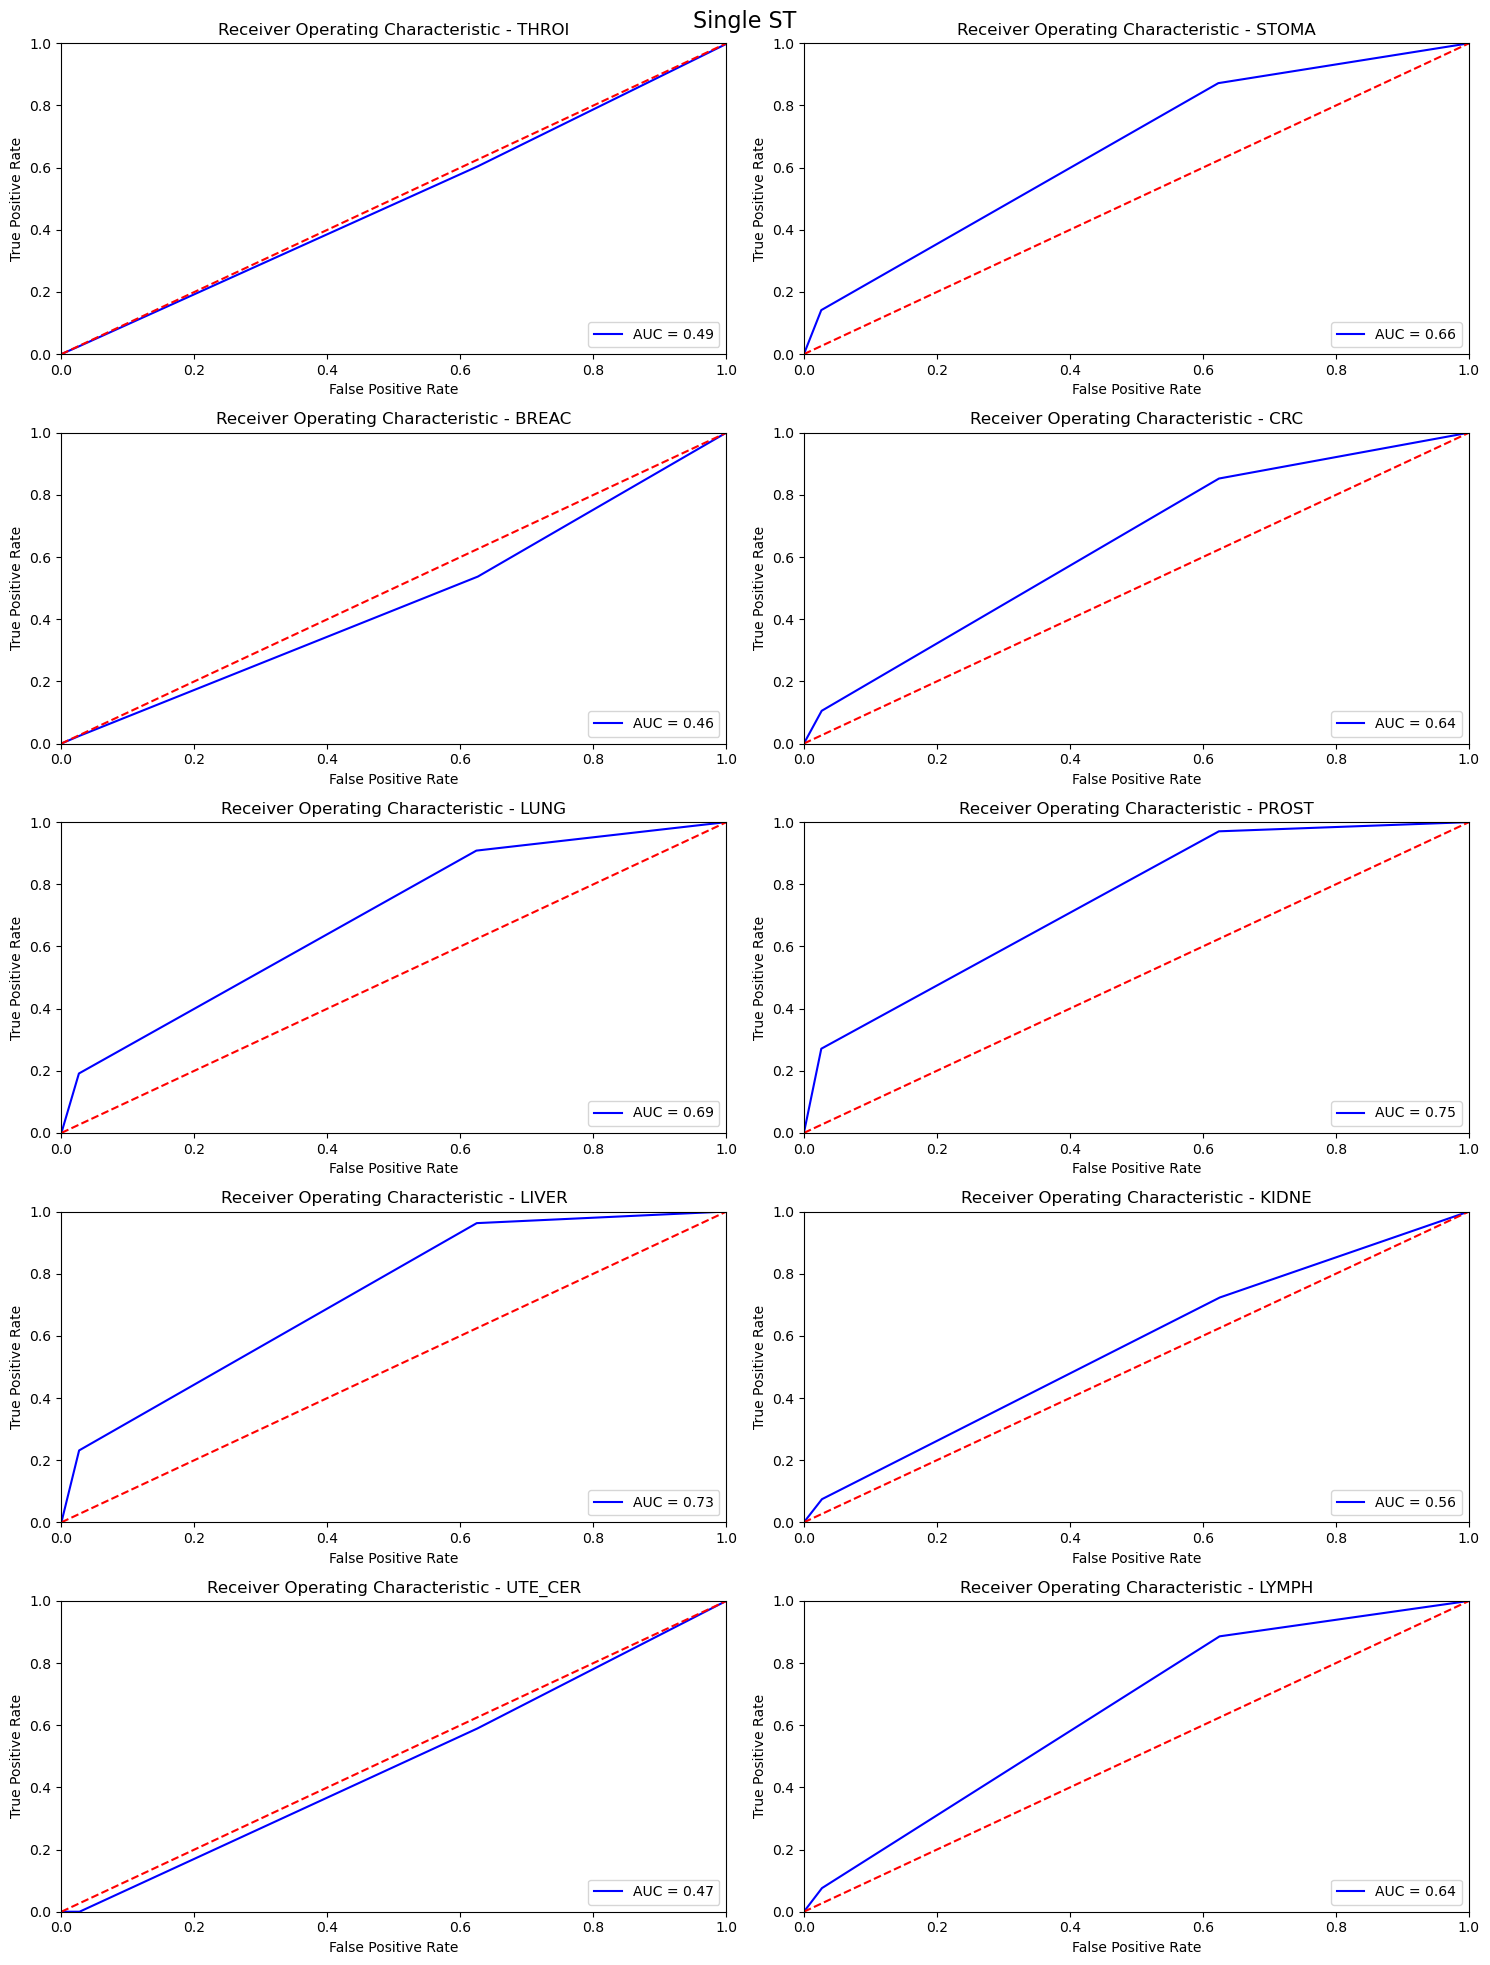

In [11]:
CUT_IDX = 1
# threshold_list_rsf = []
fig, ax = plt.subplots(5, 2)
fig.set_figheight(20)
fig.set_figwidth(15)


for i in range(len(STConfig['task'])):
	event_idx = i
	nrow = int(i / 2)
	ncol = i %2
 
	# rsf = model[f'model_{event_idx}']
	# rsf_pred_train = model_st_dict[f'model_{i}'].predict(df_train) #event=i
	
	# THRES = threshold_list[i]
	plot_roc(event_idx, model, df_test, df_y_test, cut_idx=CUT_IDX, model_type='st1', ax=ax[nrow, ncol], event_name=STConfig['task'][i])

fig.suptitle("Single ST", fontsize=16)
fig.tight_layout()		

##### Random Surival Forest and DeepHit

Shared inputs

In [7]:
SEED = 10
DISCRETE = True
SPARSE = True
SMP = None
WEIGHT = False
N_EPOCHS = 100
CUTS = [5, 10, 15] 
N_WORKER = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class args():
	def __init__(self):
		super(args, self).__init__()
		self.dataset = '../surv0913/dataset/ba8.csv' #yonsei_final_moa
		self.cancer = '../surv0913/dataset/cancers_new.txt'
		self.feature = '../surv0913/dataset/features.txt'
		self.test_rate = 0.2
		self.imputation = 'mean'
		self.by_sex = True
		self.tasks =  ['THROI', 'STOMA', 'BREAC', 'CRC', 'LUNG', 'PROST', 'LIVER', 'KIDNE', 'UTE_CER', 'LYMPH'] 
		self.new = True
		self.version = 2
		self.drop_normal = False
		# self.num_durations = DURATION
		self.n_epochs = N_EPOCHS
		self.n_workers = N_WORKER
		self.device = device
		
ARGS = args()      

STConfig = EasyDict(
	{
		'data': 'ysdat', 
		'num_durations': 5, 
		'horizons': CUTS, 
		'seed': 1234,
		'discrete_time': DISCRETE,
		'discrete_time_test': False
	}
)

STConfig['task'] = ARGS.tasks

set_random_seed(SEED)
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data2(STConfig, ARGS, sample=SMP)

##### Random Survival Forest

In [ ]:
# # Input for concordance_index_ipcw() ?

# time_train = df.loc[df_y_train.index]['duration'].astype(float).values
# event_train = df_y_train['event_0'].astype(bool).values
# inp_train = np.array([(event_train[i], time_train[i]) for i in range(len(event_train))], 
# 					 dtype = [('e', bool), ('t', float)])

# time_test = df.loc[df_y_test.index]['duration'].astype(float).values

# # Solving censoring survival function is zero at one or more time points
# time_train.max()
# df_time_train_near_max = 16.08333 # check time_train.max()

# # Change 12 events happened in just exact df_y_train['duration'].max() into censored
# df_y_test['event_0'][time_test > df_time_train_near_max] = 0 ## df_y_test['duration']

# event_test = df_y_test['event_0'].astype(bool).values
# inp_test = np.array([(event_test[i], time_test[i]) for i in range(len(event_test))], 
# 					dtype = [('e', bool), ('t', float)])

In [8]:
# Import hparams
hp_list = get_hp('./implement_checkpoints/tuned_hparams_rsf_ysdat.txt')
hp_list_dict = [json.loads(item) for item in hp_list]
hp_list_dict

[{'task': '0', 'n_estimators': 50, 'max_depth': 30, 'min_smp_slit': 10},
 {'task': '1', 'n_estimators': 100, 'max_depth': 10, 'min_smp_slit': 50},
 {'task': '2', 'n_estimators': 100, 'max_depth': 5, 'min_smp_slit': 50},
 {'task': '3', 'n_estimators': 200, 'max_depth': 10, 'min_smp_slit': 5},
 {'task': '4', 'n_estimators': 200, 'max_depth': 5, 'min_smp_slit': 10},
 {'task': '5', 'n_estimators': 200, 'max_depth': 30, 'min_smp_slit': 5},
 {'task': '6', 'n_estimators': 200, 'max_depth': 20, 'min_smp_slit': 25},
 {'task': '7', 'n_estimators': 500, 'max_depth': 10, 'min_smp_slit': 5},
 {'task': '8', 'n_estimators': 50, 'max_depth': 10, 'min_smp_slit': 50},
 {'task': '9', 'n_estimators': 500, 'max_depth': 5, 'min_smp_slit': 5}]

Train 10 RSF models

In [ ]:
# model_rsf = {}
# X = df_train.values

# for i in range(10):
# 	event_idx = i
# 	tuned_hp = hp_list_dict[event_idx]
	
# 	# Prepare input
# 	y = Surv.from_arrays(df_y_train[f"event_{event_idx}"], df_y_train["duration"]) ##

# 	# Fit RSF model
# 	model_rsf[f'model_{event_idx}'] = RandomSurvivalForest(n_estimators=tuned_hp['n_estimators'], 
# 							max_depth=tuned_hp['max_depth'],
# 							min_samples_split=tuned_hp['min_smp_slit'], 
# 							random_state=SEED)
# 	model_rsf[f'model_{event_idx}'].fit(X, y)


In [ ]:
# # Save the trained models
# with open('./optuna_ckt/model_rsf_dictionary.pkl', 'wb') as f:
# 	pickle.dump(model_rsf, f)
	
# # Load the dictionary back
# with open('./optuna_ckt/model_rsf_dictionary.pkl', 'rb') as f:
# 	loaded_models = pickle.load(f)

# print(loaded_models)

In [9]:
# Load the dictionary back
with open('./optuna_ckt/model_rsf_dict[0].pkl', 'rb') as f:
	model_dict1 = pickle.load(f)

with open('./optuna_ckt/model_rsf_dict[1, 2, 3].pkl', 'rb') as f:
	model_dict2 = pickle.load(f)
 
with open('./optuna_ckt/model_rsf_dict[4, 5, 6].pkl', 'rb') as f:
	model_dict3 = pickle.load(f)
 
with open('./optuna_ckt/model_rsf_dict[7, 8, 9].pkl', 'rb') as f:
	model_dict4 = pickle.load(f)

In [10]:
model_rsf_dict = model_dict1 | model_dict2 | model_dict3 | model_dict4
model_rsf_dict

{'model_0': RandomSurvivalForest(max_depth=30, min_samples_split=10, n_estimators=50,
                      random_state=10),
 'model_1': RandomSurvivalForest(max_depth=10, min_samples_split=50, random_state=10),
 'model_2': RandomSurvivalForest(max_depth=5, min_samples_split=50, random_state=10),
 'model_3': RandomSurvivalForest(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=10),
 'model_4': RandomSurvivalForest(max_depth=5, min_samples_split=10, n_estimators=200,
                      random_state=10),
 'model_5': RandomSurvivalForest(max_depth=30, min_samples_split=5, n_estimators=200,
                      random_state=10),
 'model_6': RandomSurvivalForest(max_depth=20, min_samples_split=25, n_estimators=200,
                      random_state=10),
 'model_7': RandomSurvivalForest(max_depth=10, min_samples_split=5, n_estimators=500,
                      random_state=10),
 'model_8': RandomSurvivalForest(max_depth=10, min_samples_split=50, n

In [12]:
model_rsf0 = model_dict1['model_0']

surv_func = model_rsf0.predict_survival_function(df_test, return_array=True)

model_rsf0.predict(df_test)

array([0.12767852, 0.12308906, 0.11674005, ..., 0.03038095, 0.04185451,
       0.02135931])

Test rsf on some examples

In [39]:
def plot_roc_rsf(event_idx, model, df_test, df_y_test, cut_idx=1, cuts=[5, 10, 15], model_type='rsf', ax=None, event_name=None, preds=None, threshold=None): #, threshold

	surv_func = model.predict_survival_function(df_test, return_array=True)
	time_points = [0] + cuts
	preds = calculate_hazard(surv_func, time_points)
	clf = preds[:, cut_idx+1] #> threshold
	clf_np = clf.astype(int)

	y_test = df_y_test[f'event_{event_idx}'] # ground truth labels
	y_probas = clf_np  # predicted probabilities generated by sklearn classifier
	fpr, tpr, threshold = metrics.roc_curve(y_test, y_probas)
	roc_auc = metrics.auc(fpr, tpr)

	event_name = event_name if event_name else event_idx
 
	# else:
	plt.title(f'Receiver Operating Characteristic - {event_name}')
	plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
	plt.legend(loc = 'lower right')
	plt.plot([0, 1], [0, 1],'r--')
	plt.xlim([0, 1])
	plt.ylim([0, 1])
	plt.ylabel('True Positive Rate')
	plt.xlabel('False Positive Rate')
	plt.show()

In [32]:
event_idx = 0

# rsf.predict(df_test.values)
surv_func = model_dict1[f'model_{event_idx}'].predict_survival_function(df_test, return_array=True)
time_points = [0] + CUTS
hazard_rates = calculate_hazard(surv_func, time_points)

# rsf_pred_train = pd.Series(model_dict1[f'model_{event_idx}'].predict(df_train.values), name='rsf_pred')
# df_y_train2 = copy.deepcopy(df_y_train)
# df_y_train2['duration'] = df.loc[df_y_train2.index, 'duration']

# rsf_pred.values
# threshold_0 = calculate_c_index_for_threshold((df_train, df_y_train2), event_idx=event_idx, cut_idx=1, risk_scores=rsf_pred_train.values, c_ind=False, verbose=False)


# THRES = 0.26467661368068307 #threshold_0
# plot_roc(event_idx, model_dict1[f'model_{event_idx}'], df_test, df_y_test, model_type='rsf')

preds = model_dict1[f'model_{event_idx}'].predict(df_test)
preds

array([0.12767852, 0.12308906, 0.11674005, ..., 0.03038095, 0.04185451,
       0.02135931])

Loop through tasks

In [ ]:
# rsf_pred_train = pd.Series(rsf.predict(df_train.values), name='rsf_pred')

In [49]:
df_y_test
sum(y_probas)
y_probas

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
preds[:, CUT_IDX+1].astype(int)

array([0, 0, 0, ..., 0, 0, 0])

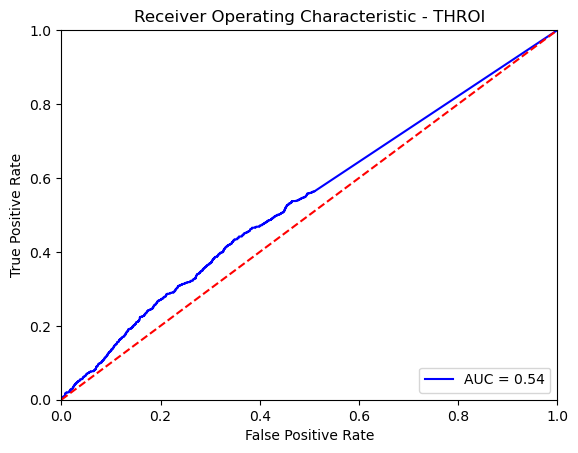

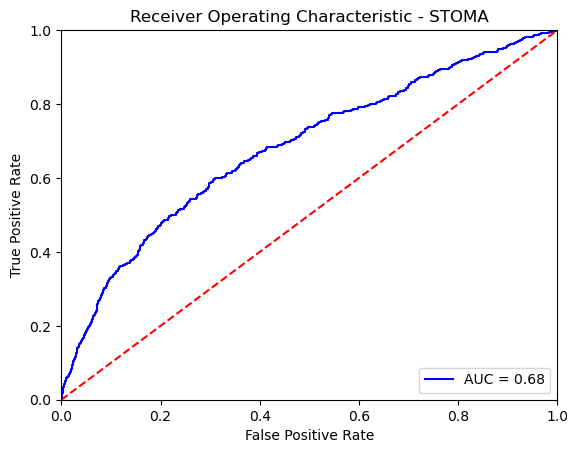

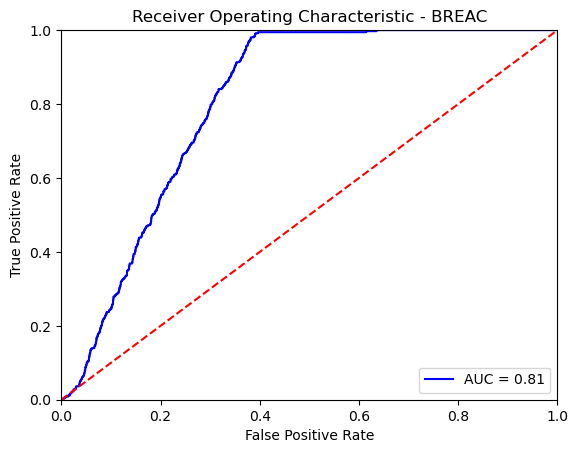

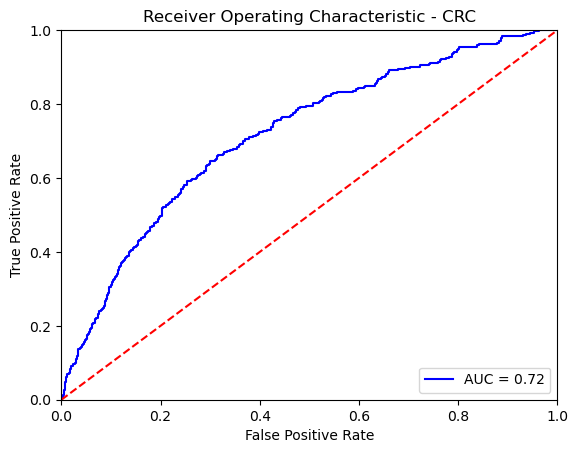

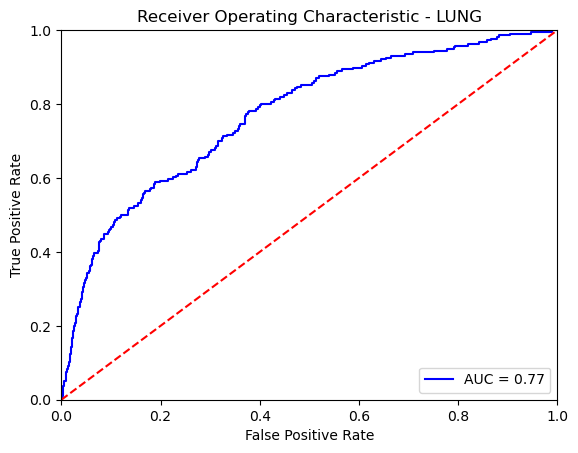

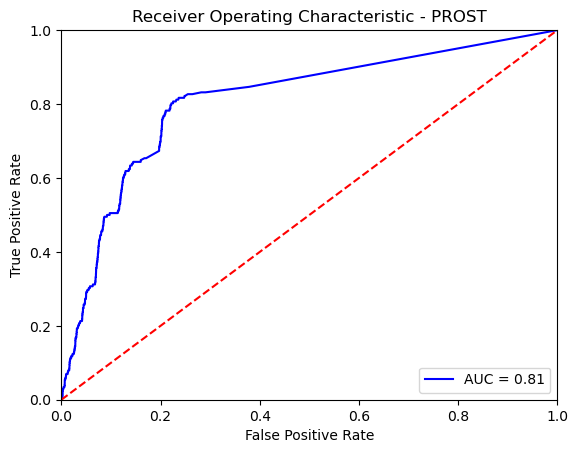

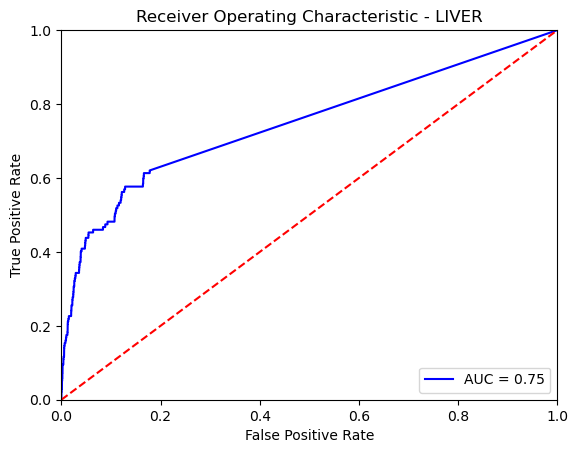

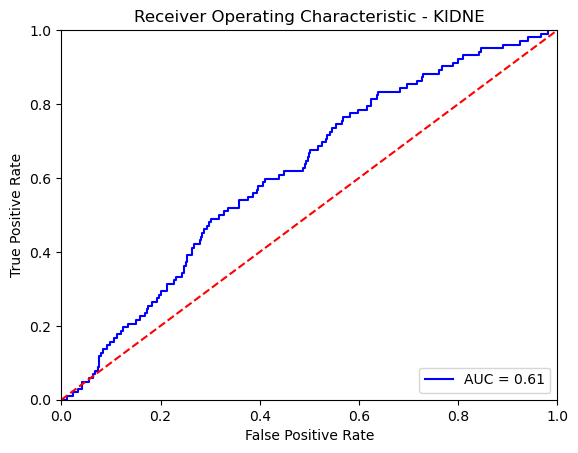

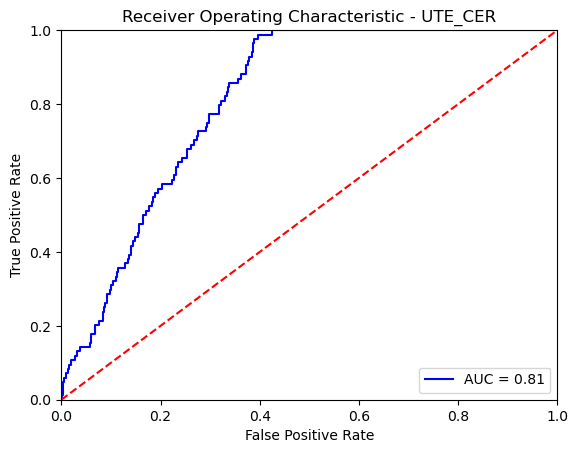

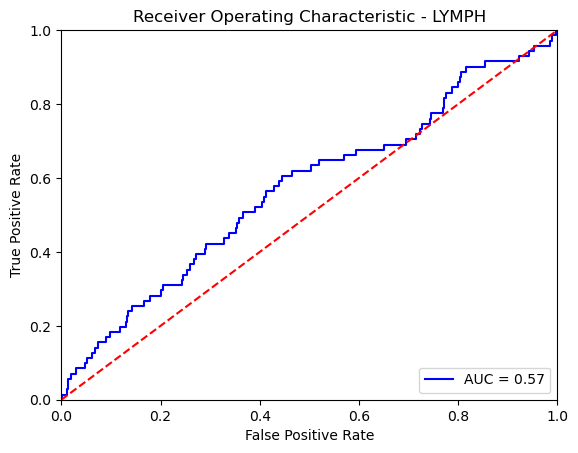

In [54]:
CUT_IDX = 1
# threshold_list_rsf = []

for i in range(10):
	event_idx = i
	rsf = model_rsf_dict[f'model_{event_idx}']
 
	surv_func = rsf.predict_survival_function(df_test, return_array=True)
	time_points = [0] + CUTS
	preds = calculate_hazard(surv_func, time_points)
	clf = preds[:, CUT_IDX+1] #> threshold
	clf_np = clf #.astype(int)

	y_test = df_y_test[f'event_{event_idx}'] # ground truth labels
	y_probas = clf_np  # predicted probabilities generated by sklearn classifier
	fpr, tpr, threshold = metrics.roc_curve(y_test, y_probas)
	roc_auc = metrics.auc(fpr, tpr)

	event_name = STConfig['task'][event_idx]  #if event_name else event_idx

	# print(fpr, tpr)
	# print('AUC: ', roc_auc)
	plt.title(f'Receiver Operating Characteristic - {event_name}')
	plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
	plt.legend(loc = 'lower right')
	plt.plot([0, 1], [0, 1],'r--')
	plt.xlim([0, 1])
	plt.ylim([0, 1])
	plt.ylabel('True Positive Rate')
	plt.xlabel('False Positive Rate')
	plt.show()

In [ ]:
CUT_IDX = 1
threshold_list_rsf = [0.26467661368068307,
 0.050430456206785546,
 0.039407110174940564,
 0.04160694861557096,
 0.016008294572460252,
 0.3855791245791247,
 0.13047237939000342,
 0.02604900719559118,
 0.02202115309275155,
 0.00837616502216378]
fig, ax = plt.subplots(5, 2)
fig.set_figheight(20)
fig.set_figwidth(15)

for i in range(10):
	event_idx = i
	nrow = int(i / 2)
	ncol = i %2
 
	rsf = model_rsf_dict[f'model_{event_idx}']
	# threshold = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=event_idx, cut_idx=CUT_IDX, risk_scores=rsf_pred_train.value, c_ind=False, verbose=True)
	# threshold_list_rsf.append(threshold)
	
	THRES = threshold_list_rsf[i] #threshold
	plot_roc(event_idx, THRES, rsf, df_test, df_y_test, cut_idx=CUT_IDX, model_type='rsf', ax=ax[nrow, ncol], event_name=STConfig['task'][i])
 
fig.suptitle("Random Surival Forest", fontsize=16)
fig.tight_layout()

##### DeepHit

In [ ]:
x_train, x_val, x_test = df_train.to_numpy(dtype=np.float32), df_val.to_numpy(dtype=np.float32), df_test.to_numpy(dtype=np.float32)

y_train = de_encode(df_y_train)
y_val = de_encode(df_y_val)
y_test = de_encode(df_y_test)
durations_test, events_test = y_test[0], y_test[1]
val = (x_val, y_val)


In [ ]:
# Load hparams
tuned_hp = {'dropout': 0.3670128477974749, 'learning_rate': 0.032129571898262724, 'batch_size': 512}
in_features = x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = len(ARGS.tasks) #y_train[1].max()
labtrans_cuts = np.array([0]+STConfig['horizons']+[df["duration"].max()])
out_features = len(labtrans_cuts)
batch_norm = True
dropout = tuned_hp['dropout']
epochs = 512
batch_size = tuned_hp['batch_size']
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = False

net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
					   out_features, batch_norm, dropout)

optimizer = tt.optim.AdamWR(lr=tuned_hp['learning_rate'], decoupled_weight_decay=0.01,
							cycle_eta_multiplier=0.8)
model_dh = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
				duration_index=labtrans_cuts, specific_time=None)


In [ ]:
log = model_dh.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

In [ ]:
model_dh.save_model_weights('optuna_ckt/deephit0124.pth')

Try load saved state dict and compare with model_dh - LATER

In [ ]:
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
					   out_features, batch_norm, dropout)

optimizer = tt.optim.AdamWR(lr=tuned_hp['learning_rate'], decoupled_weight_decay=0.01,
							cycle_eta_multiplier=0.8)
model_dh2 = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
				duration_index=labtrans_cuts, specific_time=None)

model_dh2.load_model_weights('optuna_ckt/deephit0124.pth')

model_dh2 == model_dh

In [ ]:
# pred_train = model_dh.predict(df_train.values.astype('float32'))

Example for event 5

In [ ]:
event_idx = 5
cut_idx = 1
threshold_5_dh = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=event_idx, cut_idx=cut_idx, risk_scores=pred_train[:, event_idx, cut_idx+1], c_ind=False, verbose=False)

In [ ]:
event_idx = 5
THRES = threshold_5_dh
plot_roc(event_idx, THRES, model_dh, df_test, df_y_test, model_type='deephit')

Loop and subplots

In [ ]:
CUT_IDX = 1
threshold_list_dh = []
fig, ax = plt.subplots(5, 2)
fig.set_figheight(20)
fig.set_figwidth(15)

pred_train = model_dh.predict(df_train.values.astype('float32'))
pred_test = model_dh.predict(df_test.values.astype('float32'))

for i in range(len(STConfig['task'])):
	event_idx = i
	nrow = int(i / 2)
	ncol = i %2
 
	# rsf = model[f'model_{event_idx}']
	# rsf_pred_train = model.predict(df_train, event=i)
	threshold = calculate_c_index_for_threshold((df_train, df_y_train), event_idx=event_idx, cut_idx=CUT_IDX, risk_scores=pred_train[:, i, CUT_IDX+1], c_ind=False, verbose=False)
	threshold_list_dh.append(threshold)
	
	THRES = threshold #_list[i]
	plot_roc(event_idx, THRES, model_dh, df_test, df_y_test, cut_idx=CUT_IDX, model_type='deephit', ax=ax[nrow, ncol], event_name=STConfig['task'][i], preds=pred_test)

fig.suptitle("DeepHit", fontsize=16)
fig.tight_layout()	

In [ ]:
threshold_list_dh

#### Multiple curves into one model

Load RSF

In [8]:
# Load the dictionary back
with open('./optuna_ckt/model_rsf_dict[0].pkl', 'rb') as f:
	model_dict1 = pickle.load(f)

with open('./optuna_ckt/model_rsf_dict[1, 2, 3].pkl', 'rb') as f:
	model_dict2 = pickle.load(f)
 
with open('./optuna_ckt/model_rsf_dict[4, 5, 6].pkl', 'rb') as f:
	model_dict3 = pickle.load(f)
 
with open('./optuna_ckt/model_rsf_dict[7, 8, 9].pkl', 'rb') as f:
	model_dict4 = pickle.load(f)

model_rsf_dict = model_dict1 | model_dict2 | model_dict3 | model_dict4
model_rsf_dict

{'model_0': RandomSurvivalForest(max_depth=30, min_samples_split=10, n_estimators=50,
                      random_state=10),
 'model_1': RandomSurvivalForest(max_depth=10, min_samples_split=50, random_state=10),
 'model_2': RandomSurvivalForest(max_depth=5, min_samples_split=50, random_state=10),
 'model_3': RandomSurvivalForest(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=10),
 'model_4': RandomSurvivalForest(max_depth=5, min_samples_split=10, n_estimators=200,
                      random_state=10),
 'model_5': RandomSurvivalForest(max_depth=30, min_samples_split=5, n_estimators=200,
                      random_state=10),
 'model_6': RandomSurvivalForest(max_depth=20, min_samples_split=25, n_estimators=200,
                      random_state=10),
 'model_7': RandomSurvivalForest(max_depth=10, min_samples_split=5, n_estimators=500,
                      random_state=10),
 'model_8': RandomSurvivalForest(max_depth=10, min_samples_split=50, n

In [9]:
threshold_list_rsf = [0.26467661368068307,
 0.050430456206785546,
 0.039407110174940564,
 0.04160694861557096,
 0.016008294572460252,
 0.3855791245791247,
 0.13047237939000342,
 0.02604900719559118,
 0.02202115309275155,
 0.00837616502216378]

Load DeepHit

In [10]:
tuned_hp = {'dropout': 0.3670128477974749, 'learning_rate': 0.032129571898262724, 'batch_size': 512}
in_features = df_train.shape[1] #x_train.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = len(ARGS.tasks) #y_train[1].max()
labtrans_cuts = np.array([0]+STConfig['horizons']+[df["duration"].max()])
out_features = len(labtrans_cuts)
batch_norm = True
dropout = tuned_hp['dropout']
epochs = 512
batch_size = tuned_hp['batch_size']
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = False

net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
					   out_features, batch_norm, dropout)

optimizer = tt.optim.AdamWR(lr=tuned_hp['learning_rate'], decoupled_weight_decay=0.01,
							cycle_eta_multiplier=0.8)
model_dh = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
				duration_index=labtrans_cuts, specific_time=None)

model_dh.load_model_weights('optuna_ckt/deephit0124.pth')

In [11]:
event_idx = 0
pred_dh = model_dh.predict(df_test.values.astype('float32'))
pred_dh.shape

(46373, 10, 5)

In [10]:
threshold_list_dh = [1.273865090476142,
 0.46310225400057714,
 0.2603469424777547,
 -0.13430789745215233,
 -0.5905708616430116,
 -0.5189576305524284,
 -1.5353522300720215,
 -1.944260953652738,
 -0.8344051386370808,
 -2.1254687538050643]

Load ST

In [14]:
hp_list = get_hp('./implement_checkpoints/tuned_hparams_single_ysdat.txt') 
hp_list_dict = [json.loads(item) for item in hp_list]

# Retrieving from ./optuna_ckt/trialrun1229_ysdat_single.txt
model_st29_list = [
    # '24-12-29_18.19.22_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task0',
   	'24-12-29_17.07.33_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task0', # trial 10 instead
    '24-12-29_22.39.14_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task1',
    # '24-12-30_06.03.22_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task2',
    '24-12-30_01.19.02_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task2', # trial 10 instead
	'24-12-30_11.06.02_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task3',
	'24-12-30_13.07.04_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task4',
	'24-12-30_15.15.40_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task5',
	'24-12-30_18.55.57_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task6',
	'24-12-30_20.56.25_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task7',
	# '24-12-31_00.46.37_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task8',
	'24-12-30_22.34.23_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task8', # trial 10 instead
	'24-12-31_06.13.31_ST-ysdat-single_sparseFalse_cuts[5, 10, 15]_task9'
    ]

model_st_dict = {}

for i in range(len(STConfig['task'])): # Should be 10
	tuned_hp = next((item for item in hp_list_dict if item["task"] == f'E{i}'), None) #json.loads(hp_list[E])

	STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
	STConfig['hidden_size'] = tuned_hp['hidden_size']
	STConfig['intermediate_size'] = tuned_hp['intermediate_size']
	STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
	STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

	model = SurvTraceSingle(STConfig).to("cuda")
	model.load_state_dict(torch.load(f'./implement_checkpoints/trial_training/{model_st29_list[i]}.pt'))
	model = model.to('cpu')
	model_st_dict[f'model_{i}'] = model

Load CanAttend group 1 & 2

In [15]:
# from survtrace.config import STConfig
SEED = 29
CUTS = [5, 10, 15]
TEST_BATCH = None
UNIT = 'years'
SPARSE = True
ALL_CEN = True

# STConfig['duration_index'] = 
# STConfig['horizons'] = CUTS
STConfig['initializer_range'] = .02
STConfig['early_stop_patience'] = 5
STConfig['layer_norm_eps'] =  1e-12
STConfig['hidden_dropout_prob'] = 0.0
STConfig['chunk_size_feed_forward'] = 0
STConfig['pruned_heads'] = {}
STConfig['output_hidden_states'] = False
STConfig['output_attentions'] = False

GROUP_LIST = [[0, 1, 5, 6, 7, 8, 9],
			  [2, 3, 4, 5, 6, 7, 8, 9],
			  [i for i in range(10)]]

PATH_LIST = ['./implement_checkpoints/trial_training/24-12-14_03.31.10_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group0.pt', 
			 './implement_checkpoints/trial_training/24-12-15_02.56.08_ST-ysdat_sparseTrue_cuts[5, 10, 15]_group1.pt']

hp_list = get_hp('./implement_checkpoints/tuned_hparams_tag_ysdat.txt')
hp_list_dict = [json.loads(item) for item in hp_list]

model_ca = {}
for group_idx in range(2):
	task_indices = GROUP_LIST[group_idx]
	STConfig['task'] = [ARGS.tasks[i] for i in task_indices]
	STConfig['num_event'] = len(STConfig['task'])
				
	set_random_seed(SEED)

	# Load hyperparams
	tuned_hp = next((item for item in hp_list_dict if item["group"] == str(group_idx)), None) #json.loads(hp_list[E])
 
	STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
	STConfig['hidden_size'] = tuned_hp['hidden_size']
	STConfig['intermediate_size'] = tuned_hp['intermediate_size']
	STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
	STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

	model_ca[f'CA group_{group_idx+1}'] = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
	model_ca[f'CA group_{group_idx+1}'].load_state_dict(torch.load(PATH_LIST[group_idx]))
	model_ca[f'CA group_{group_idx+1}'] = model_ca[f'CA group_{group_idx+1}'].to('cpu')

Using modified version of modeling_bert.py
Using modified version of modeling_bert.py


In [16]:
threshold_list_gr1 = [-2.6679717218032994,
 -3.7994330362840136,
 -4.556072115898132,
 -5.203126888082485,
 -5.186669012512823,
 -4.401677097937073,
 -5.501650184091895]

threshold_list_gr2 = [-5.497918128967285,
 -3.977186947157888,
 -4.571382128831113,
 -4.661104183606426,
 -5.008902164420695,
 -5.268686228328281,
 -6.795355103232643,
 -5.259275536344509]

In [17]:
# GROUP = 1
			
# set_random_seed(SEED)

# # Load hyperparams
# tuned_hp = next((item for item in hp_list_dict if item["group"] == str(GROUP)), None) #json.loads(hp_list[E])

# STConfig['attention_probs_dropout_prob'] = tuned_hp['dropout']
# STConfig['hidden_size'] = tuned_hp['hidden_size']
# STConfig['intermediate_size'] = tuned_hp['intermediate_size']
# STConfig['num_hidden_layers'] = tuned_hp['num_hidden_layers'] 
# STConfig['num_attention_heads'] = tuned_hp['num_attention_heads']

# model = SurvTraceMulti(STConfig, new_ver=SPARSE).to("cuda")
# model.load_state_dict(torch.load(PATH))
# model = model.to('cpu')

Plot

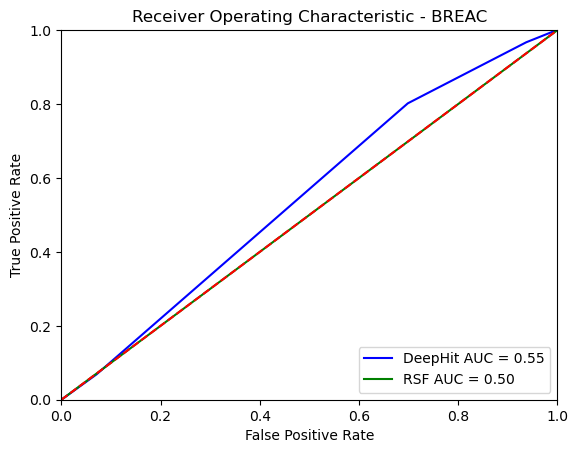

In [18]:
cut_idx = 1
event_idx = 0
event_name = STConfig['task'][event_idx]
y_test = df_y_test[f'event_{event_idx}'] 

# DeepHit 
# threshold = threshold_list_dh[event_idx]
preds = model_dh.predict(df_test.values.astype('float32'))
clf = preds[:, event_idx, cut_idx+1] #> threshold
clf_np = clf.astype(int)

y_probas = clf_np #df_y_test['clf'] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probas)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = f'DeepHit AUC = {roc_auc:.2f}')

# RSF
# threshold = threshold_list_rsf[event_idx]
surv_func = model_rsf_dict[f'model_{event_idx}'].predict_survival_function(df_test, return_array=True)
time_points = [0] + CUTS
preds = calculate_hazard(surv_func, time_points)
clf = preds[:, cut_idx] #> threshold
clf_np = clf.astype(int)

y_probas = clf_np #df_y_test['clf'] # predicted probabilities generated by sklearn classifier
fpr, tpr, threshold = metrics.roc_curve(y_test, y_probas)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = f'RSF AUC = {roc_auc:.2f}')

plt.title(f'Receiver Operating Characteristic - {event_name}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_ca.keys()

In [ ]:
threshold_dict = {'DeepHit': threshold_list_dh,
				  'RSF': threshold_list_rsf,
	  			'CanAttend group 1': threshold_list_gr1,
		 		'CanAttend group 2': threshold_list_gr2}
model_list = [model_dh, model_rsf_dict, model_ca['CA group_1'], model_ca['CA group_2']]
model_list

Plot combined ROC

In [19]:
# type(model_st_dict['model_0'].predict(df_test))
model_st_dict.keys()

dict_keys(['model_0', 'model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9'])

In [22]:
def plot_roc_combo(event_idx, 
                #    threshold_dict, 
                   model_list, model_name_list, df_test, df_y_test, cut_idx=1, cuts=[5, 10, 15], ax=None, event_name=None, preds=None):
	y_test = df_y_test[f'event_{event_idx}'] 
	
	# print('Len model_list: ', len(model_list))
	for j, mod_name in enumerate(model_name_list):
		color_list = ['m', 'c', 'y', 'r', 'b'] 
  
		if mod_name == 'DeepHit':
			# threshold = threshold_dict[mod_name][event_idx]
			preds = model_list[j].predict(df_test.values.astype('float32'))
			clf = preds[:, event_idx, cut_idx+1] ## cut+1
		 
		elif mod_name == 'RSF':
			# threshold = threshold_dict[mod_name][event_idx]
			surv_func = model_list[j][f'model_{event_idx}'].predict_survival_function(df_test, return_array=True)
			time_points = [0] + cuts
			preds = calculate_hazard(surv_func, time_points)
			clf = preds[:, cut_idx+1] #> threshold
   
		elif mod_name == 'ST':
			# threshold = threshold_dict[mod_name][event_idx_mod]
			preds = model_list[j].predict(df_test, batch_size=None) #[0]
			clf = preds[:, cut_idx+1]  ## cut+1
			clf = clf.detach().numpy()
   
		elif mod_name == 'CanAttend group 1':
			event_idx_mod =  event_idx if event_idx in [0, 1] else event_idx - 3 
			if event_idx in [0, 1]:
				color_list = ['m', 'c', 'y', 'r']  ##
    
			# threshold = threshold_dict[mod_name][event_idx_mod]
			preds = model_list[j].predict(df_test, batch_size=None, event=event_idx_mod)[0]
			clf = preds[:, cut_idx+1]  ## cut+1
			clf = clf.detach().numpy()
  		
		elif mod_name == 'CanAttend group 2':
			event_idx_mod = event_idx - 2
			if event_idx in [2, 3, 4]:
				color_list = ['m', 'c', 'y', 'b'] ## 'c', 'm'? 

			preds = model_list[j].predict(df_test, batch_size=None, event=event_idx_mod)[0]
			clf = preds[:, cut_idx+1]  ## cut+1
			clf = clf.detach().numpy()
   
		y_probas = clf # clf.astype(int) 
		fpr, tpr, threshold = metrics.roc_curve(y_test, y_probas)
		roc_auc = metrics.auc(fpr, tpr)

		if ax:
			ax.plot(fpr, tpr, color_list[j], label = f'{mod_name} AUC = {roc_auc:.2f}', ls='-', marker=None)
		
		else:
			plt.plot(fpr, tpr, color_list[j], label = f'{mod_name} AUC = {roc_auc:.2f}')
  
	if ax:
		ax.set_title(f'Receiver Operating Characteristic - {event_name}')
		ax.plot([0, 1], [0, 1],'k:', label='Reference line')
		ax.set_xlim([0, 1])
		ax.set_ylim([0, 1])
		ax.set_ylabel('True Positive Rate')
		ax.set_xlabel('False Positive Rate')
		ax.legend(loc = 'lower right')
	
	else:
		plt.title(f'Receiver Operating Characteristic - {event_name}')
		plt.legend(loc = 'lower right')
		plt.plot([0, 1], [0, 1],'k:', label='Reference line')
		plt.xlim([0, 1])
		plt.ylim([0, 1])
		plt.ylabel('True Positive Rate')
		plt.xlabel('False Positive Rate')
		plt.show()
		

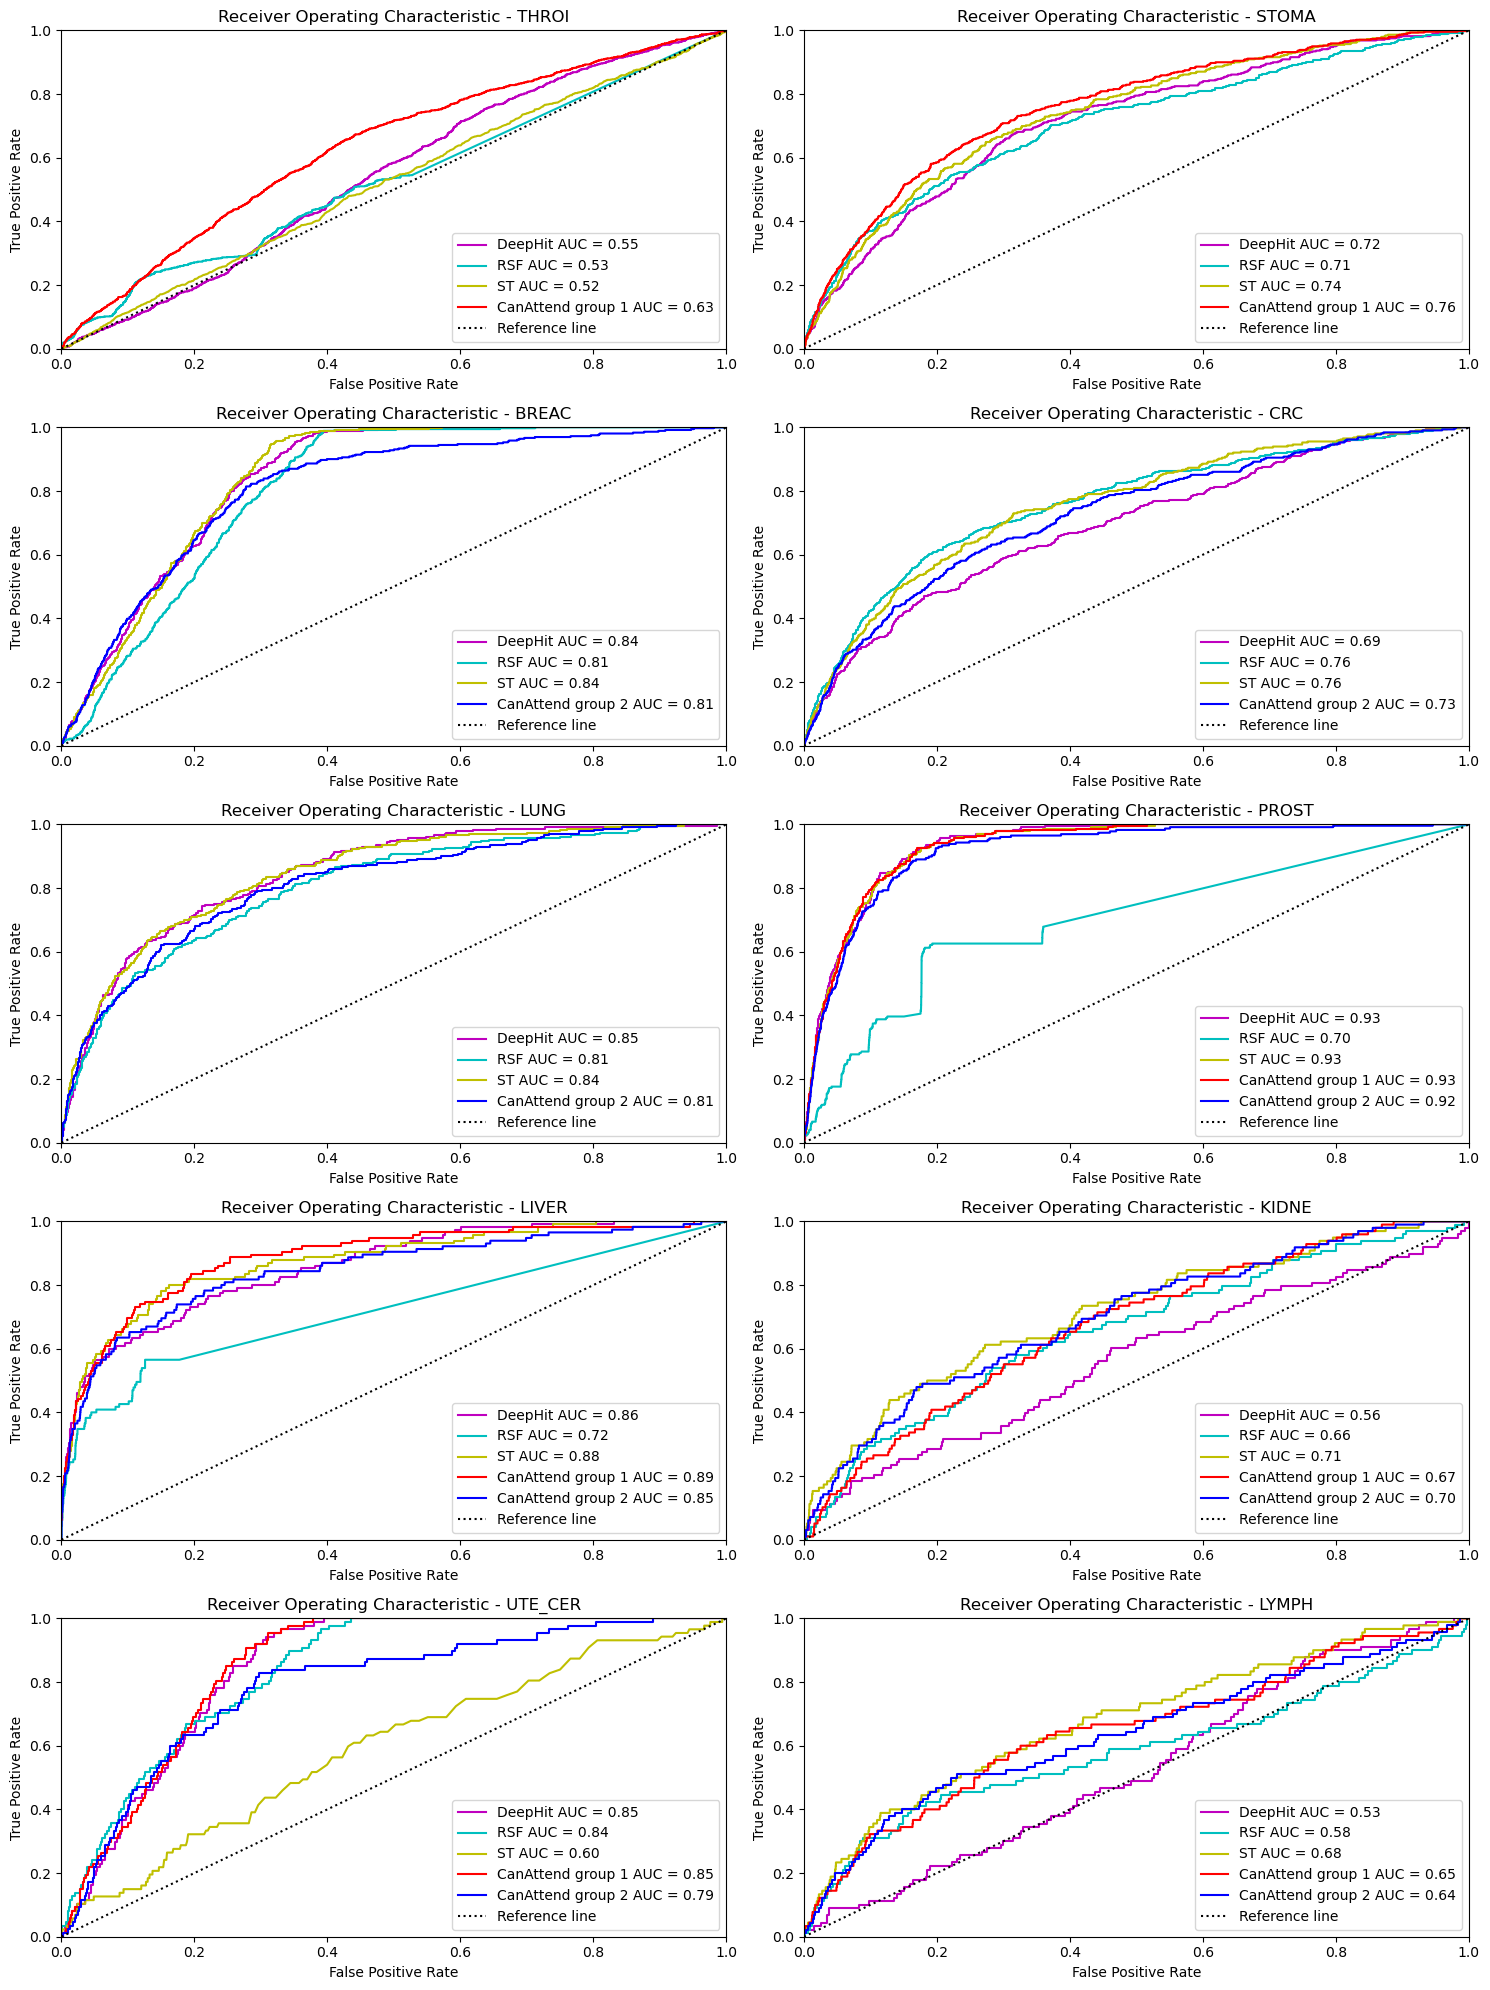

In [23]:
CUT_IDX = 1
fig, ax = plt.subplots(5, 2)
fig.set_figheight(20)
fig.set_figwidth(15)

for i in range(len(ARGS.tasks)):
	# print("i", i)
	# threshold_dict = {
    #  'DeepHit': threshold_list_dh,
	# 			  'RSF': threshold_list_rsf,
	#   			'CanAttend group 1': threshold_list_gr1,
	# 	 		'CanAttend group 2': threshold_list_gr2}
	model_name_list = ['DeepHit', 'RSF', 'ST', 'CanAttend group 1', 'CanAttend group 2'] #list(threshold_dict.keys())
	model_list = [
     model_dh, 
     model_rsf_dict,
     model_st_dict[f'model_{i}'],
     model_ca['CA group_1'], 
     model_ca['CA group_2']
	 ]
	

	event_idx = i
	nrow = int(i / 2)
	ncol = i %2

	if i in [0, 1]:
	# 	threshold_dict = {
    #   'DeepHit': threshold_list_dh,
	# 			  'RSF': threshold_list_rsf,
	#   			'CanAttend group 1': threshold_list_gr1}
		model_list = [model_list[i] for i in [0, 1, 2, 3]] #[0, 1, 2]
		model_name_list = ['DeepHit', 'RSF', 'ST', 'CanAttend group 1'] #list(threshold_dict.keys())
  
	elif i in [2, 3, 4]:
	# 	threshold_dict = {
    #   'DeepHit': threshold_list_dh,
	# 			  'RSF': threshold_list_rsf,
	#   			'CanAttend group 2': threshold_list_gr2} 
		model_list = [model_list[i] for i in [0, 1, 2, 4]] #[0, 1, 3] 
		model_name_list = ['DeepHit', 'RSF', 'ST', 'CanAttend group 2']  #list(threshold_dict.keys())
  
	plot_roc_combo(event_idx, 
                # threshold_dict, 
                model_list, model_name_list, df_test, df_y_test, cut_idx=1, cuts=[5, 10, 15], ax=ax[nrow, ncol], event_name=ARGS.tasks[i], preds=None) #task_idx_list=GROUP_LIST
 
# fig.suptitle("", fontsize=16)
fig.tight_layout()	

##### Time-dependent AUROC

https://notebook.community/sebp/scikit-survival/examples/evaluating-survival-models

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_flchain
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv

from sksurv.metrics import (concordance_index_censored,
							concordance_index_ipcw,
							cumulative_dynamic_auc)

In [ ]:
# Example
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

num_columns = ['age', 'creatinine', 'kappa', 'lambda']

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_train = imputer.transform(x_train.loc[:, num_columns])
x_test = imputer.transform(x_test.loc[:, num_columns])

y_events = y_train[y_train['death']]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test['death']]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert train_min <= test_min < test_max < train_max, \
	"time range or test data is not within time range of training data."
	
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

def plot_cumulative_dynamic_auc(risk_score, label, color=None):
	auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

	plt.plot(times, auc, marker="o", color=color, label=label)
	plt.xlabel("days from enrollment")
	plt.ylabel("time-dependent AUC")
	plt.axhline(mean_auc, color=color, linestyle="--")
	plt.legend()

	
for i, col in enumerate(num_columns):
	plot_cumulative_dynamic_auc(x_test[:, i], col, color="C{}".format(i))
	ret = concordance_index_ipcw(y_train, y_test, x_test[:, i], tau=times[-1])

In [ ]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

cph = make_pipeline(OneHotEncoder(), CoxPHSurvivalAnalysis())
cph.fit(va_x, va_y)

va_times = np.arange(7, 183, 7)
# estimate performance on training data, thus use `va_y` twice.
va_auc, va_mean_auc = cumulative_dynamic_auc(va_y, va_y, cph.predict(va_x), va_times)

plt.plot(va_times, va_auc, marker="o")
plt.axhline(va_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

Apply to group 1

In [ ]:
df_y_train2 = copy.deepcopy(df_y_train)
df_y_train2['duration'] = df.loc[df_y_train2.index, 'duration']
df_y_train2

In [ ]:
auc

In [ ]:
event_idx = 0
cut_idx = 1
preds = model.predict(df_test, batch_size=None, event=event_idx)[0]
risk_score = preds[:, cut_idx+1]

# df_y_train2 

# df_y_train2['duration'][df_y_train2['duration'] >= 15.7] = 15.69 #ValueError: all times must be within follow-up time of test data: [0.1; 15.7[
# df_y_train2['duration'][df_y_train2['duration'] <= 0.1] = 0.2
times = np.percentile(df["duration"], np.linspace(0.1, 15.7, 15)) #?

y_train = Surv.from_arrays(df_y_train2[f'event_{event_idx}'], df_y_train2['duration'])
y_test = Surv.from_arrays(df_y_test[f'event_{event_idx}'], df_y_test['duration'])

auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

plt.plot(times, auc, marker="o") #color=color, label=label
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.axhline(mean_auc, linestyle="--") #color=color
plt.legend()

In [ ]:
# df_y_train[df_y_train['duration'] > 15.7]
df_y_train2['duration'][df_y_train2['duration'] > 15.7]

In [ ]:
# df_y_train['duration']

df_y_train2 = copy.deepcopy(df_y_train)
df_y_train2['duration'] = df.loc[df_y_train2.index, 'duration']
df_y_train2

In [ ]:
df_y_train2['duration'].describe()

In [ ]:
df_y_test['duration'].describe()